# Investigation

The API homepage lets you download CSVs of historical forecast and actual CI. These are (presumably) the final forecast values for the given time window. Here I check the forecast error.

In [1]:
%matplotlib inline

import os
from collections import defaultdict
from datetime import datetime, timezone, timedelta
import numpy as np
from scipy import stats
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scrape.files import get_data_files
from scrape.graph import _ftime, _aggregate_per, get_dates, save_figure
from scrape.graph import get_merged_summaries_with_final_actual_intensities, _error_and_percentage_error
from scrape.graph import generate_distribution_plots
from scrape.investigation import cleanup, problem_magnitudes

plt.rcParams["figure.figsize"] = [12, 6]
plt.rcParams["figure.dpi"] = 250

# Get data files 2022-23
files = get_data_files("data/samples", extension=".csv")

df = pd.concat([pd.read_csv(fp, index_col=0) for fp in sorted(files)])

# Drop duplicates from overlapping dates
df = df[~df.index.duplicated(keep="last")]

df.index = pd.to_datetime(df.index)

In [2]:
df["error"] = df["Forecast Carbon Intensity (gCO2/kWh)"].sub(df["Actual Carbon Intensity (gCO2/kWh)"])
df["percentage error"] = 100. * df["error"].div(df["Actual Carbon Intensity (gCO2/kWh)"])
df.tail()

,Actual Carbon Intensity (gCO2/kWh),Forecast Carbon Intensity (gCO2/kWh),Index,error,percentage error
Datetime (UTC),,,,,
2023-03-30 22:00:00+00:00,81.0,139,low,58.0,71.604938
2023-03-30 22:30:00+00:00,77.0,129,low,52.0,67.532468
2023-03-30 23:00:00+00:00,78.0,105,low,27.0,34.615385
2023-03-30 23:30:00+00:00,77.0,85,low,8.0,10.389610
2023-03-31 00:00:00+00:00,82.0,81,low,-1.0,-1.219512


In [3]:
# Get unique years from the index and plot by year
years = list({dt.year: "" for dt in df.index}.keys())

plt.rcParams['figure.figsize'] = [12, 48]
plt.rcParams['figure.dpi'] = 250

col = "percentage error"

fig, axes = plt.subplots(len(years), 1, sharex=False, sharey="col")
for ix, ax in enumerate(axes):
    dates = [d for d in df.index if d.year == years[ix]]
    df.loc[dates, [col]].plot(ax=ax, linewidth=0.5)
    
    title = f"{_ftime(dates[0])} - {_ftime(dates[-1])} UTC"
    ax.text(0.5, 0.95, title, horizontalalignment='center', verticalalignment='top', transform = ax.transAxes)
    
#     ax.set_title()
    ax.set_ylabel("forecast % error")
    ax.grid("on", linestyle="--", alpha=0.33)
    ax.hlines(
        0.0,
        ax.get_xlim()[0],
        ax.get_xlim()[-1],
        color="k",
        linestyle="--",
        linewidth=0.5,
    )
    
    # The mean absolute percentage error for the entire period, and the standard deviation (of the raw errors)
    year_mean = df.loc[dates, [col]].abs().mean()
    year_std = df.loc[dates, [col]].std()
    year_range = df.loc[dates, [col]].min(), df.loc[dates, [col]].max()
    print(f"{dates[0].year}: mean {float(year_mean)}, std {float(year_std)}, range {float(year_range[0])}, {float(year_range[1])}")

ax.set_ylim(-100,100)
plt.show()

2017: mean 9.176311999523838, std 13.679474837027618, range -45.25547445255474, 114.99999999999999
2018: mean 10.822421092169625, std 34.67726398646401, range -91.11969111969111, 1570.1754385964912
2019: mean 5.908749639934832, std 56.70681449783952, range -96.0, 4366.776315789474
2020: mean 6.315442144994107, std 9.279700400943442, range -96.57142857142857, 134.6938775510204
2021: mean 5.450166185300275, std 8.016490329398568, range -83.42245989304813, 96.35036496350365
2022: mean 6.401842465289679, std 10.512159106586562, range -54.63414634146342, 444.44444444444446
2023: mean 7.907825272072335, std 12.748422111917812, range -65.67164179104478, 305.0


### All years

In [ ]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 250

def adjust_axes(ax, measure: str):
    ax.set_ylim(-150,150)
    ax.set_title(f"{_ftime(df.index[0])} - {_ftime(df.index[-1])} UTC")
    ax.set_ylabel("forecast " + measure)
    ax.grid("on", linestyle="--", alpha=0.33)
    ax.hlines(
        0.0,
        ax.get_xlim()[0],
        ax.get_xlim()[-1],
        color="k",
        linestyle="--",
        linewidth=0.5,
    )

    xticks = ax.get_xticks()
    xlabels = ax.get_xticklabels()

    ax.set_xticks(xticks, xlabels, rotation=90, ha="center")

    # locator = mdates.MonthLocator(interval=1)  # every month
    locator = mdates.YearLocator()             # every year
    fmt = mdates.DateFormatter("%Y-%b")
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(fmt)
    
def print_summary(df: pd.DataFrame, measure: str):
    # The mean absolute error or percentage for the entire period, and the standard deviation (of the raw errors)
    year_mean = df[measure].abs().mean()
    year_std = df[measure].std()
    year_range = df[measure].min(), df[measure].max()
    print(f"{df.index[0].year}-{df.index[-1].year}: mean absolute {measure} {float(year_mean)}, std {float(year_std)}, range {float(year_range[0])}, {float(year_range[1])}")
    print(df.index[0], df.index[-1])

2017-2023: mean absolute error 13.707219561594126, std 72.58573587113902, range -288.0, 13275.0
2017-09-11 23:30:00+00:00 2023-03-31 00:00:00+00:00


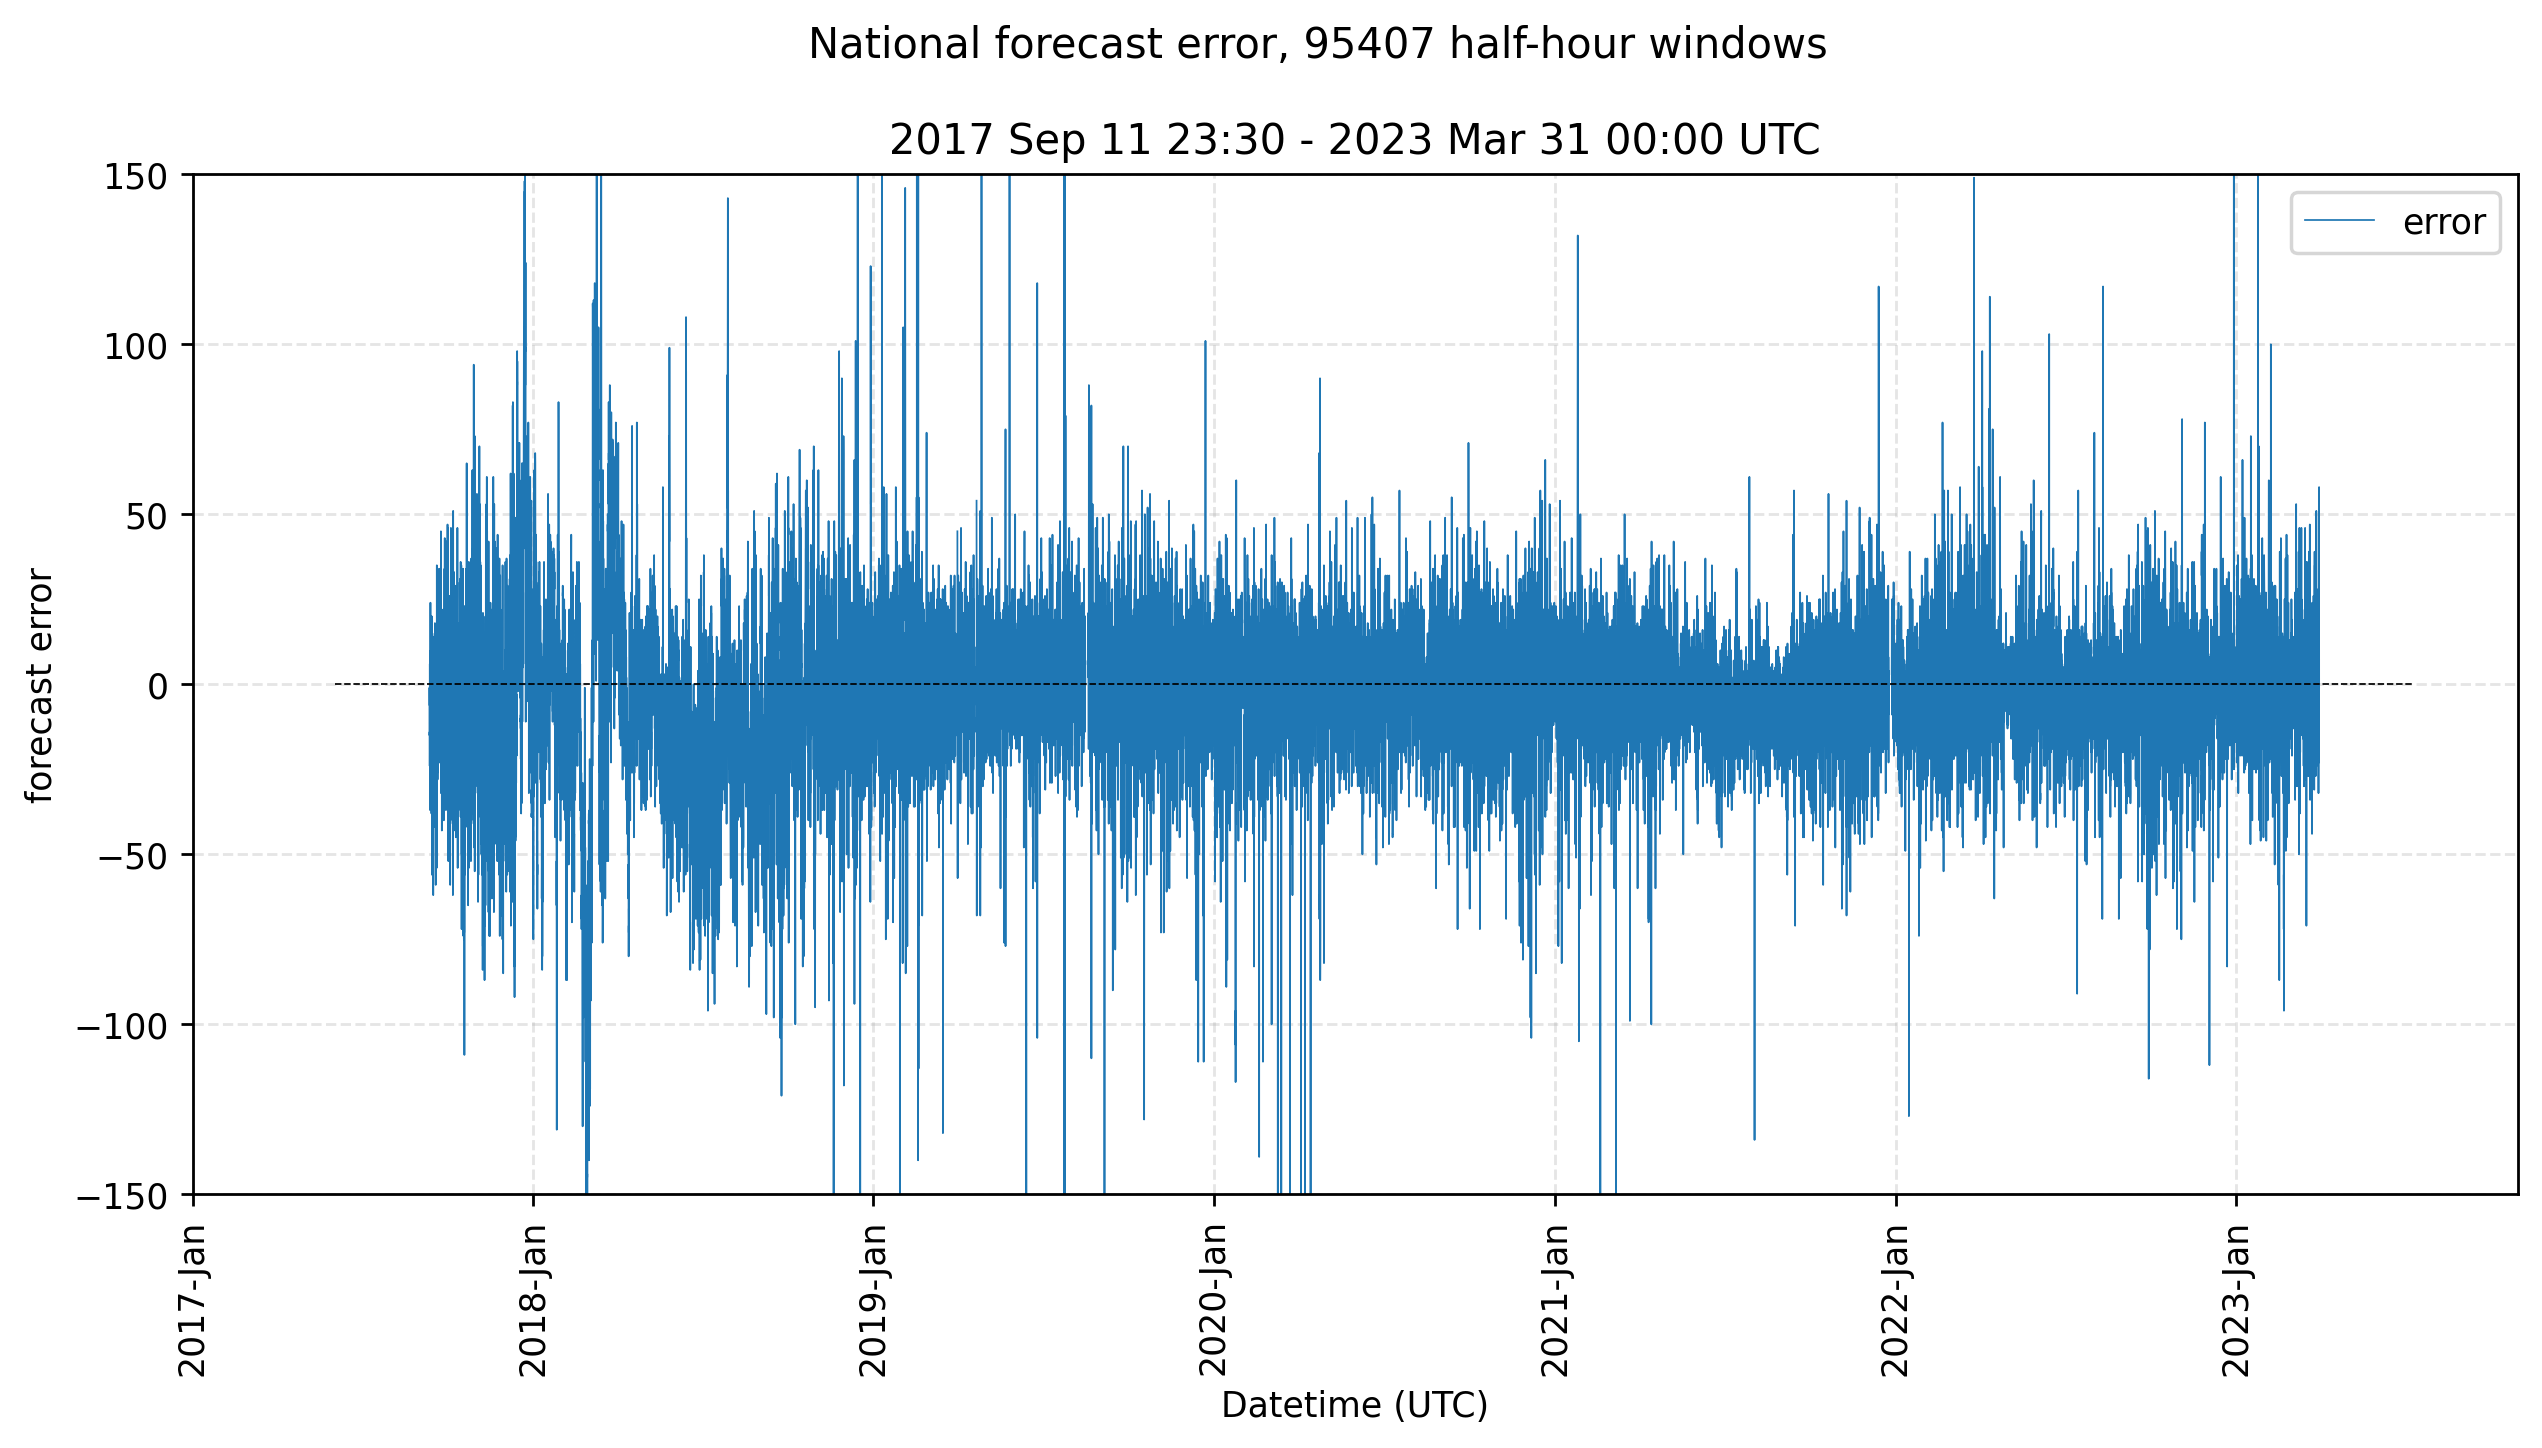

In [5]:
measure = "error"
ax = df.plot(use_index=True, y=measure, linewidth=0.5, label=measure)
adjust_axes(ax, measure)
print_summary(df, measure)

fig = plt.gcf()
fig.suptitle(f"National forecast error, {len(df.index)} half-hour windows")
save_figure(fig, "./charts", "ci_forecast_error_2017-2023.png")
plt.show()

2017-2023: mean absolute percentage error 7.147381369675848, std 29.26346713524063, range -96.57142857142857, 4366.776315789474
2017-09-11 23:30:00+00:00 2023-03-31 00:00:00+00:00


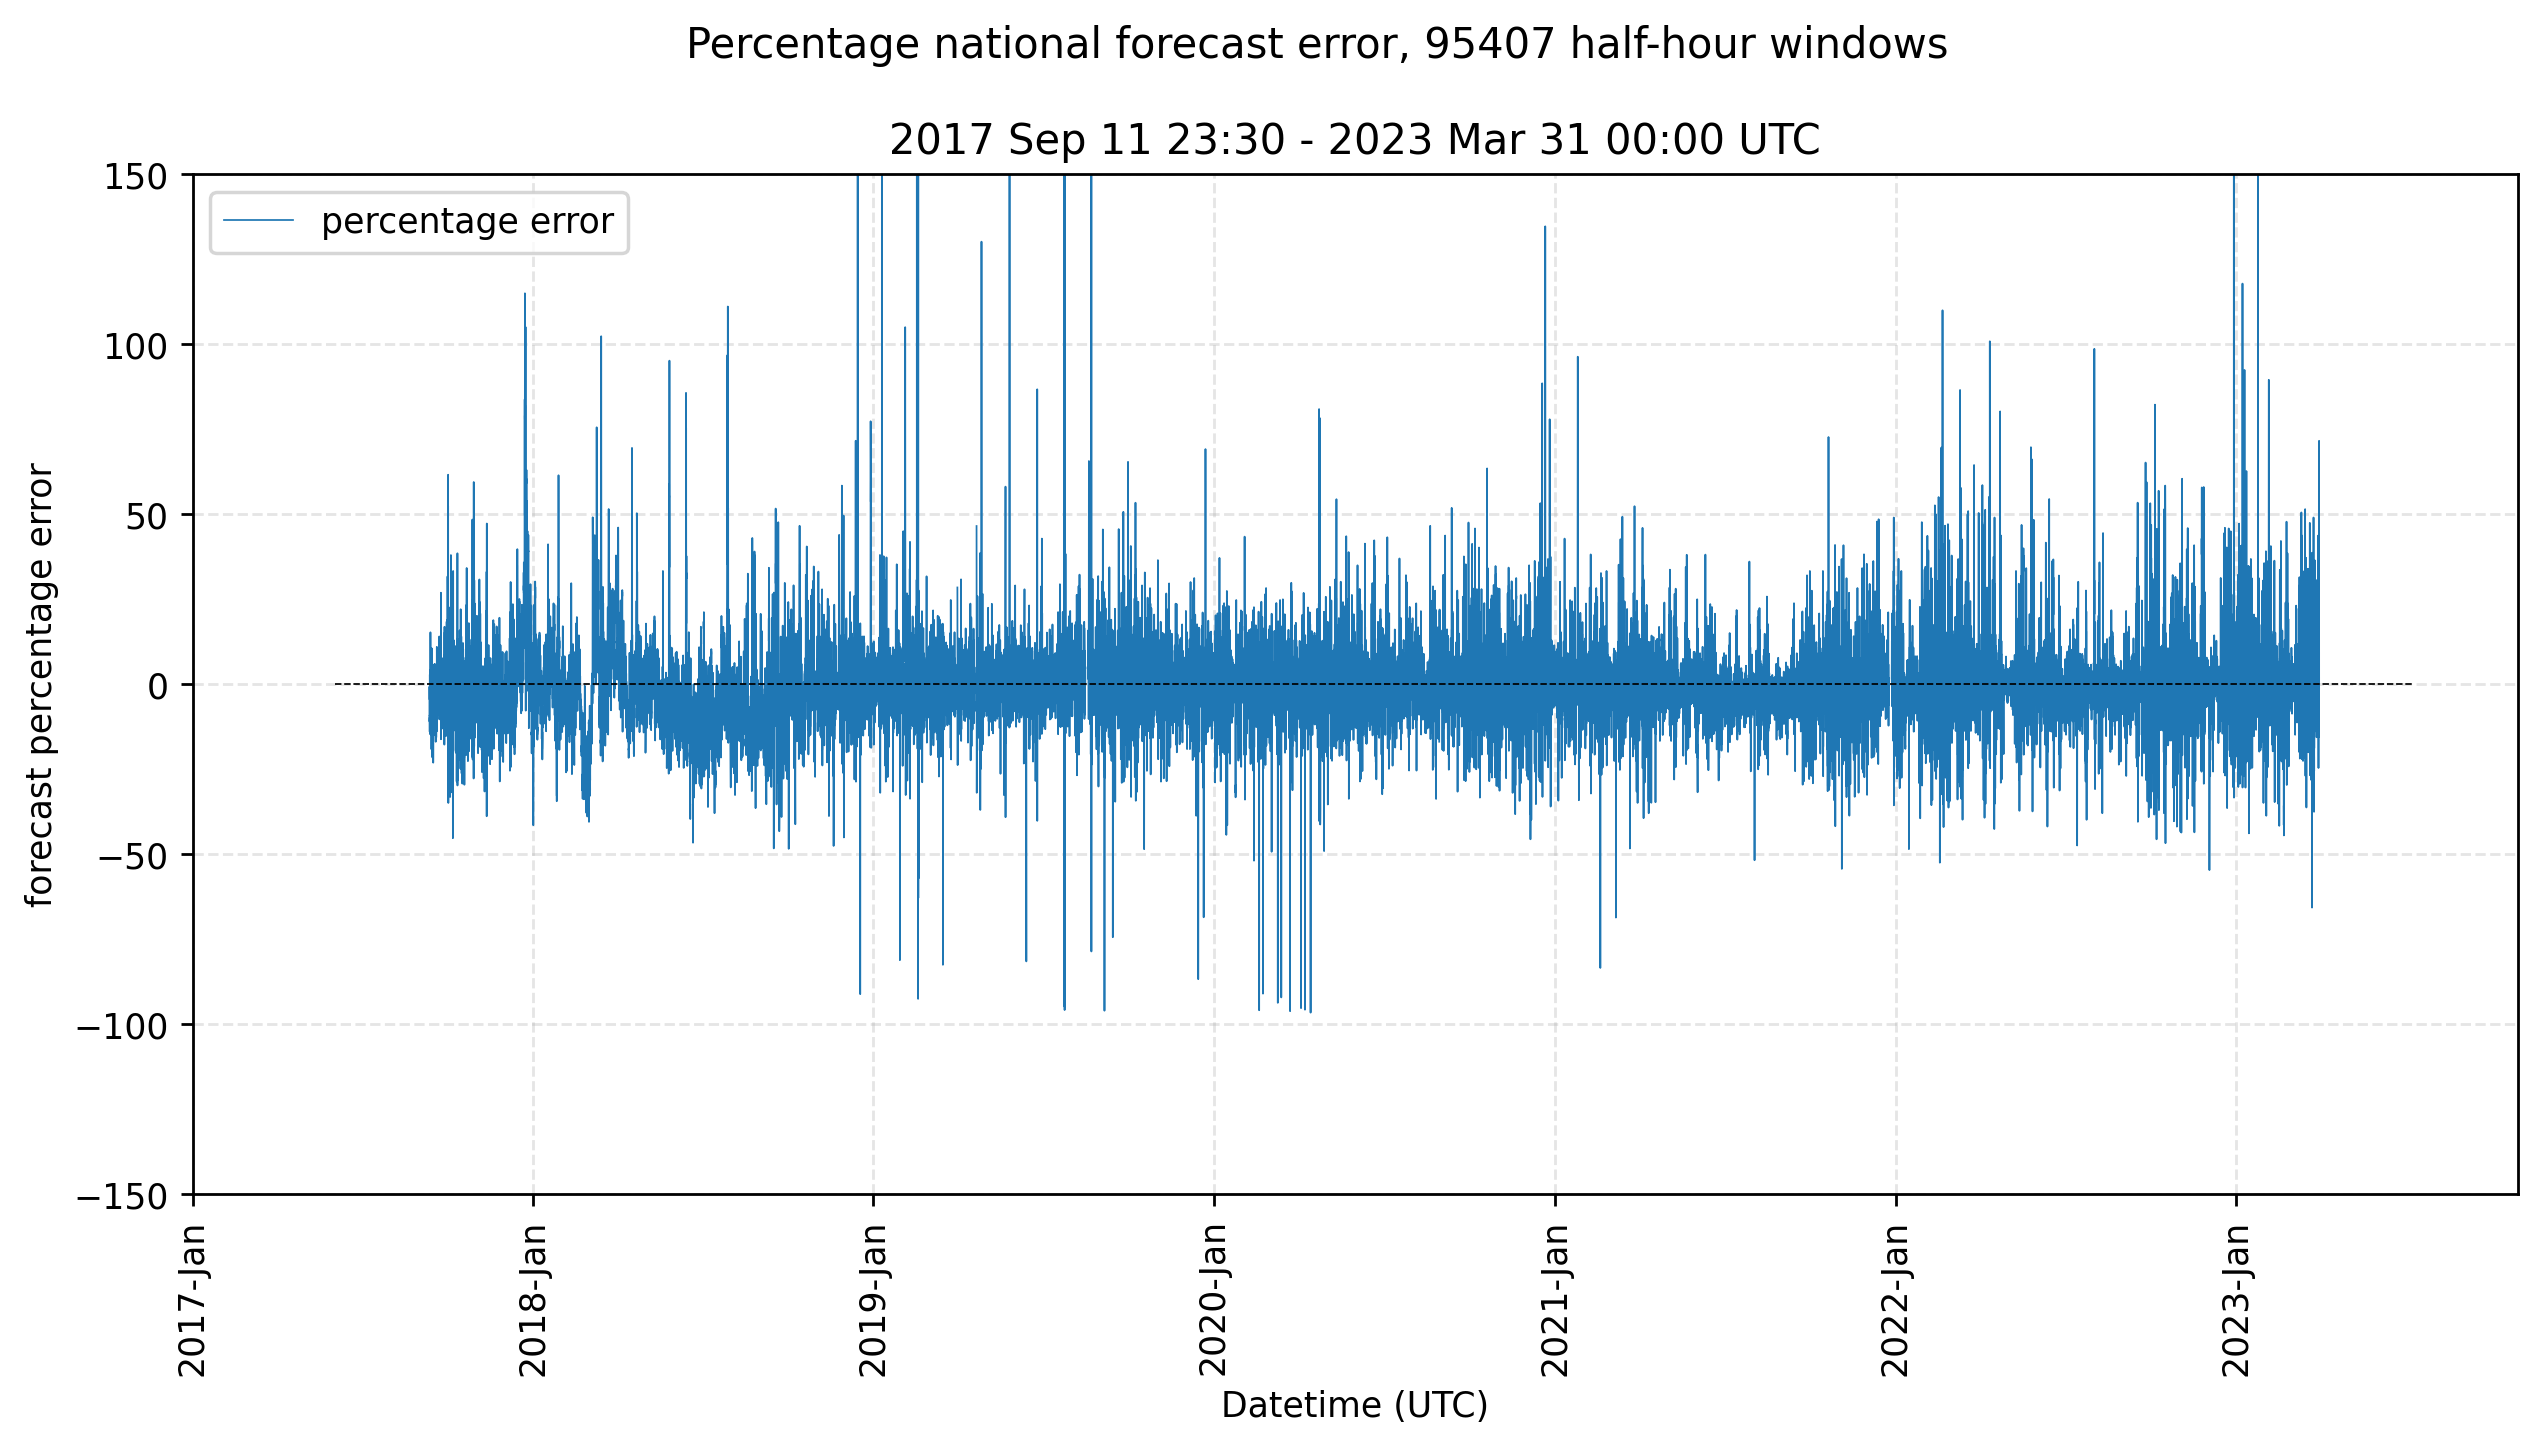

In [6]:
measure = "percentage error"
ax = df.plot(use_index=True, y=measure, linewidth=0.5, label=measure)
adjust_axes(ax, measure)
print_summary(df, measure)

fig = plt.gcf()
fig.suptitle(f"Percentage national forecast error, {len(df.index)} half-hour windows")
save_figure(fig, "./charts", "ci_pc_forecast_error_2017-2023.png")
plt.show()

## Problematic errors

How big can an error be before it is problematic?

This depends upon the published CI index boundaries.

In [7]:
# The index ranges
df_ci = pd.read_csv("data/artifacts/ci_index_numerical_bands.csv", index_col=0, header=[0,1])
df_ci

very low      low      moderate      high      very high
Year / Index     from  to from   to     from   to from   to      from
2017                0  99  100  199      200  299  300  400       401
2018                0  79   80  179      180  279  280  380       381
2019                0  59   60  159      160  259  260  360       361
2020                0  54   55  149      150  229  230  350       351
2021                0  49   50  139      140  219  220  330       331
2022                0  44   45  129      130  209  210  310       311
2023                0  39   40  119      120  199  200  290       291
2024                0  34   35  109      110  189  190  270       271
2025                0  29   30   99      100  179  180  250       251
2026                0  24   25   89       90  169  170  230       231
2027                0  19   20   79       80  159  160  210       211
2028                0  14   15   69       70  149  150  190       191
2029                0   9   10   59       60  139  140  170       171
2030                0   4    5   49       50  129  130  150       151

In [8]:
cols = [(title, metric) for title in ["moderate - very low", "high - low", "very high - moderate"] for metric in ["difference", "percentage"]]

df_comp = pd.DataFrame(columns=pd.MultiIndex.from_tuples(cols), index=df_ci.index)

for ix, row in df_ci.iterrows():
    diff = row["moderate"]["from"] - row["very low"]["to"]
    df_comp.loc[ix, pd.IndexSlice["moderate - very low", "difference"]] = diff
    df_comp.loc[ix, pd.IndexSlice["moderate - very low", "percentage"]] = 100. * diff / row["moderate"]["from"]
    
    diff = row["high"]["from"] - row["low"]["to"]
    df_comp.loc[ix, pd.IndexSlice["high - low", "difference"]] = diff
    df_comp.loc[ix, pd.IndexSlice["high - low", "percentage"]] = 100. * diff / row["high"]["from"]
    
    diff = row["very high"]["from"] - row["moderate"]["to"]
    df_comp.loc[ix, pd.IndexSlice["very high - moderate", "difference"]] = diff
    df_comp.loc[ix, pd.IndexSlice["very high - moderate", "percentage"]] = 100. * diff / row["very high"]["from"]
    
df_comp.to_csv("data/artifacts/ci_index_numerical_band_error_scales.csv", index=True)
df_comp

moderate - very low            high - low             \
              difference percentage difference percentage   
2017                 101       50.5        101  33.666667   
2018                 101  56.111111        101  36.071429   
2019                 101     63.125        101  38.846154   
2020                  96       64.0         81  35.217391   
2021                  91       65.0         81  36.818182   
2022                  86  66.153846         81  38.571429   
2023                  81       67.5         81       40.5   
2024                  76  69.090909         81  42.631579   
2025                  71       71.0         81       45.0   
2026                  66  73.333333         81  47.647059   
2027                  61      76.25         81     50.625   
2028                  56       80.0         81       54.0   
2029                  51       85.0         81  57.857143   
2030                  46       92.0         81  62.307692   

     very high - moderate             
               difference percentage  
2017                  102  25.436409  
2018                  102  26.771654  
2019                  102  28.254848  
2020                  122  34.757835  
2021                  112  33.836858  
2022                  102  32.797428  
2023                   92   31.61512  
2024                   82  30.258303  
2025                   72  28.685259  
2026                   62  26.839827  
2027                   52   24.64455  
2028                   42  21.989529  
2029                   32   18.71345  
2030                   22  14.569536

In [9]:
# More conservative ranges

cols = [(title, metric) for title in ["low - mid very low", "moderate - mid low", "high - mid moderate", "very high - mid high"] for metric in ["difference"]]
df_comp_mid = pd.DataFrame(columns=pd.MultiIndex.from_tuples(cols), index=df_ci.index)
for ix, row in df_ci.iterrows():
    mid = row["very low"]["from"] + (row["very low"]["to"] - row["very low"]["from"]) / 2.
    diff = row["low"]["from"] - mid
    df_comp_mid.loc[ix, pd.IndexSlice["low - mid very low", "difference"]] = diff
    
    mid = row["low"]["from"] + (row["low"]["to"] - row["low"]["from"]) / 2.
    diff = row["moderate"]["from"] - mid
    df_comp_mid.loc[ix, pd.IndexSlice["moderate - mid low", "difference"]] = diff
    
    mid = row["moderate"]["from"] + (row["moderate"]["to"] - row["moderate"]["from"]) / 2.
    diff = row["high"]["from"] - mid
    df_comp_mid.loc[ix, pd.IndexSlice["high - mid moderate", "difference"]] = diff
    
    mid = row["high"]["from"] + (row["high"]["to"] - row["high"]["from"]) / 2.
    diff = row["very high"]["from"] - mid
    df_comp_mid.loc[ix, pd.IndexSlice["very high - mid high", "difference"]] = diff
    
df_comp_mid

,low - mid very low,moderate - mid low,high - mid moderate,very high - mid high
,difference,difference,difference,difference
2017,50.5,50.5,50.5,51.0
2018,40.5,50.5,50.5,51.0
2019,30.5,50.5,50.5,51.0
2020,28.0,48.0,40.5,61.0
2021,25.5,45.5,40.5,56.0
2022,23.0,43.0,40.5,51.0
2023,20.5,40.5,40.5,46.0
2024,18.0,38.0,40.5,41.0
2025,15.5,35.5,40.5,36.0


These are the absolute CI values ($gCO_2/kWh$) and percentage errors necessary (from the measured value) for a forecast to cross two index boundaries, e.g. from `very low` to `moderate`.

In [10]:
# Get the minimum percentages necessary to transition two boundaries (e.g. very low -> moderate)
print("percentage", problem_magnitudes(2023, "percentage"))
print("difference", problem_magnitudes(2023, "difference"))

percentage [67.5, 40.5, 31.61512027491409]
difference [81, 81, 92]


## How likely are such errors?

Fit errors to a distribution.

### Historical data (2017-2023)

Only one error is available per timepoint.

17 excluded outliers, 609 nans, leaving 94781 data points
22 excluded outliers, 609 nans, leaving 94776 data points


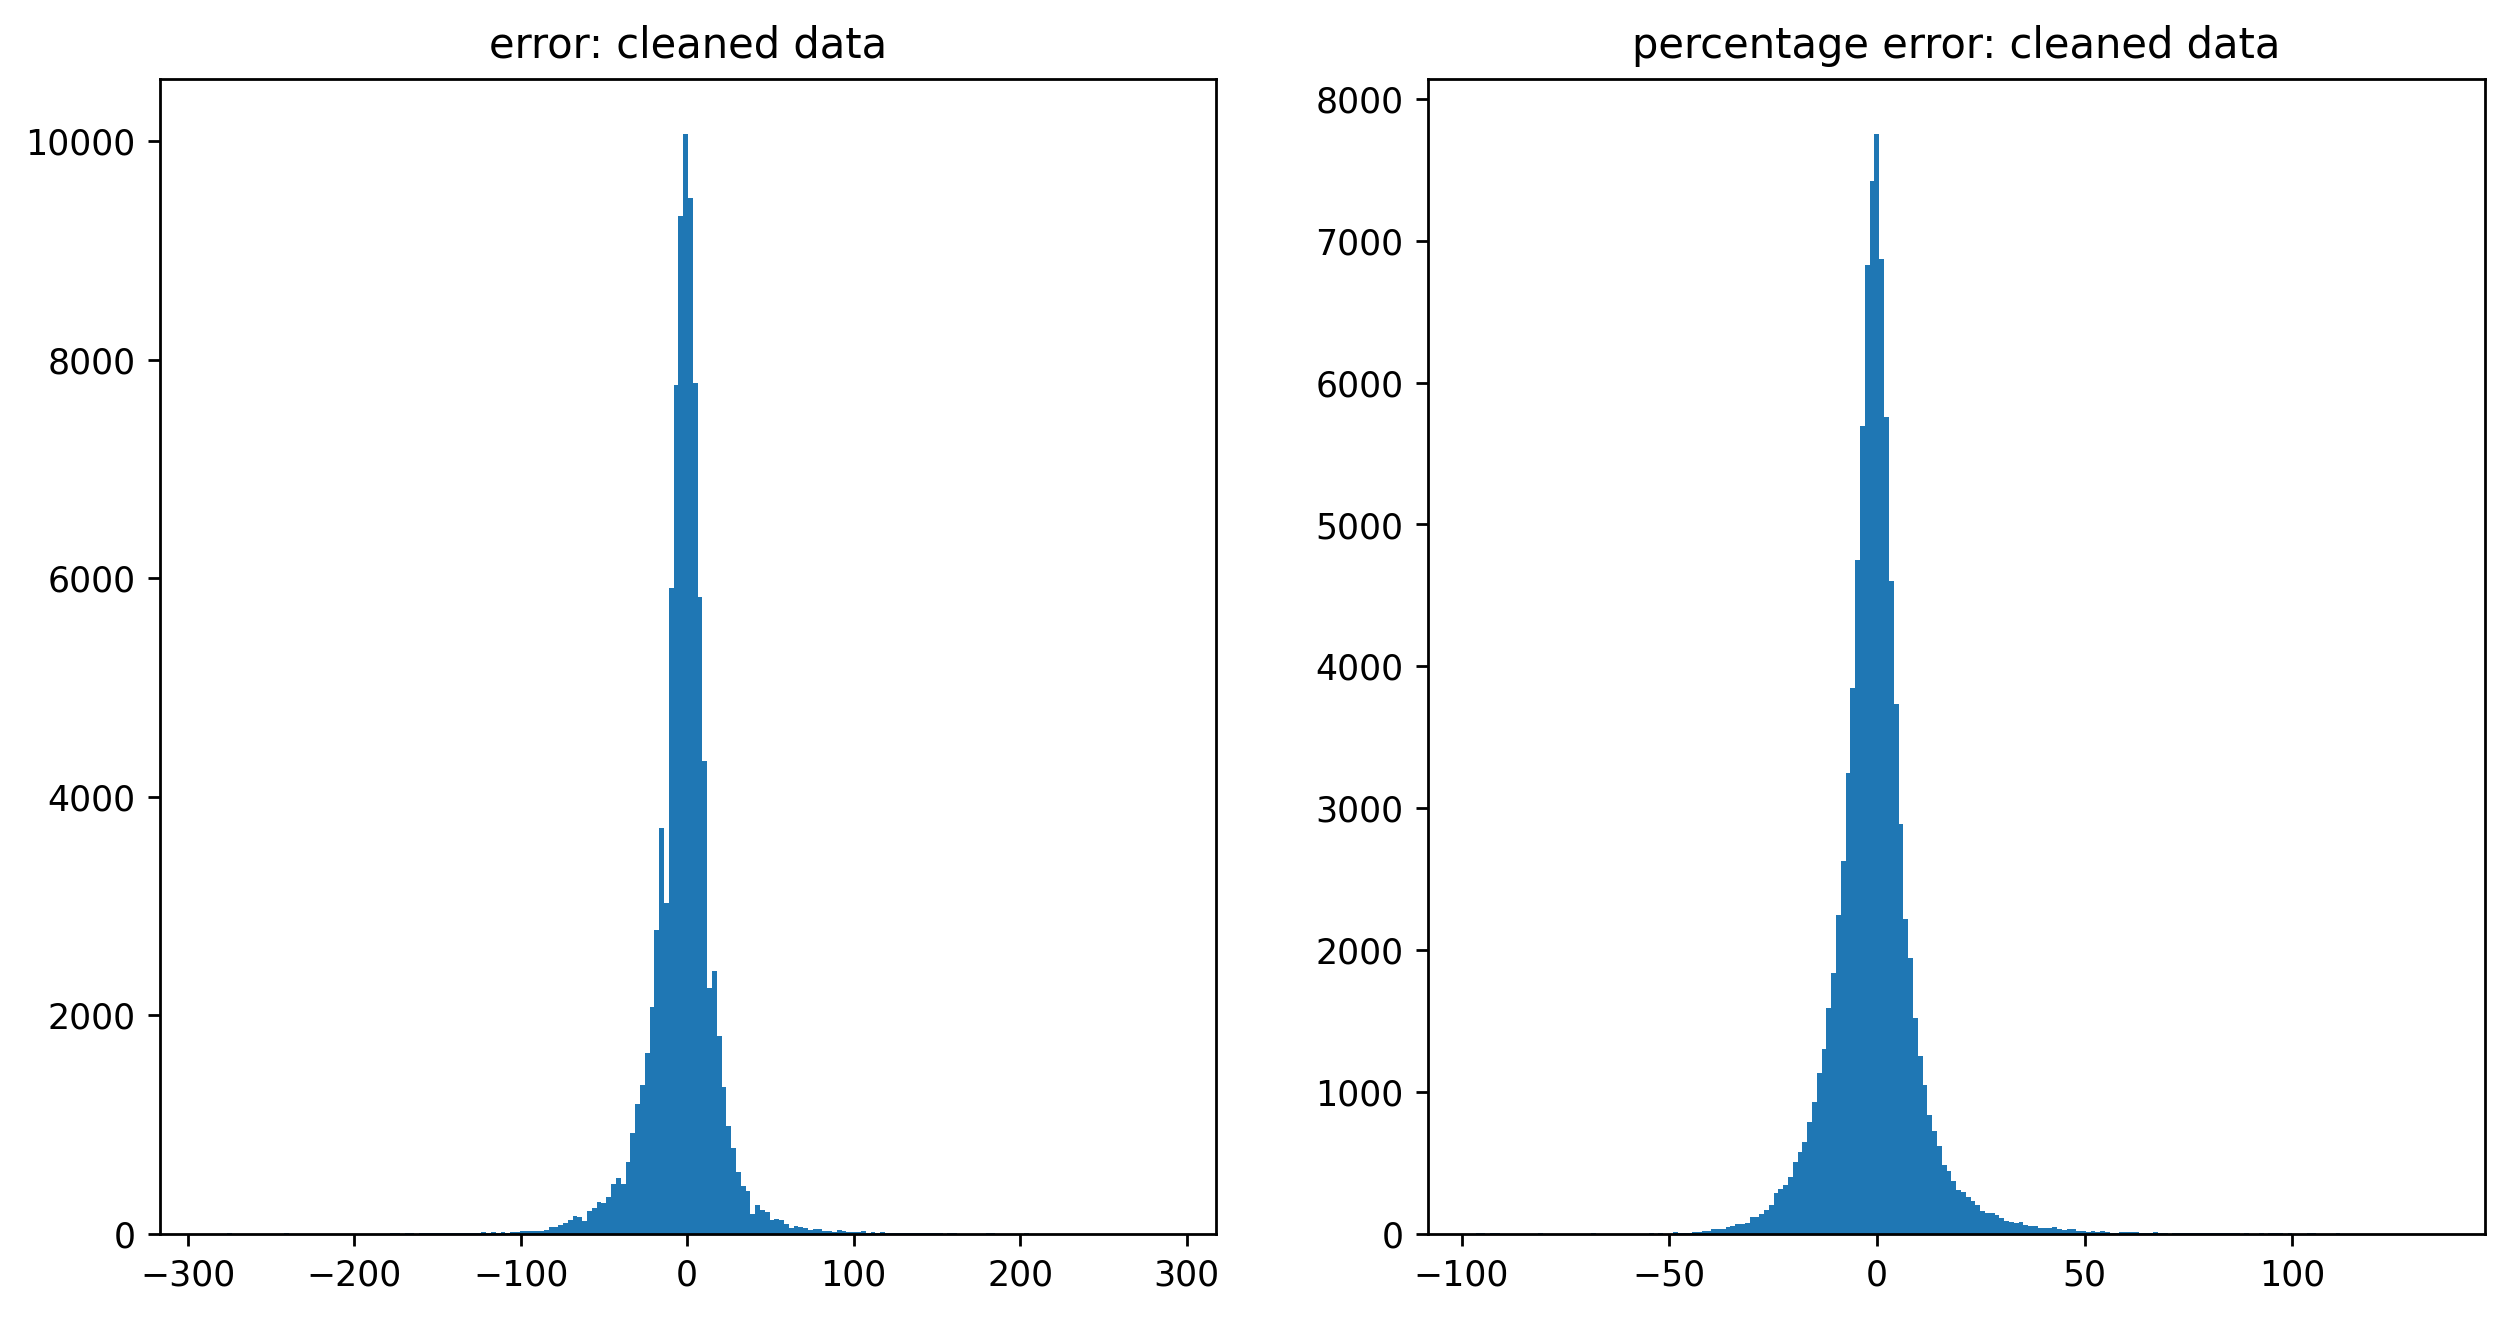

In [11]:
data_historical_err = cleanup(df, "error", max_cutoff=300)
data_historical_pc_err = cleanup(df, "percentage error", max_cutoff=150)

fig, ax = plt.subplots(1,2)
ax[0].hist(data_historical_err, bins=200)
ax[0].set_title(f"error: cleaned data")
ax[1].hist(data_historical_pc_err, bins=200)
ax[1].set_title(f"percentage error: cleaned data")
plt.show()

Only 39 out of over 95000 data points have a magnitude over 100% error.

Normal distribution parameters:
{'mean': -1.147537155417298, 'standard deviation': 11.679356759690293}
Student's t distribution parameters:
{'mean': -1.1506783362283046, 'standard deviation': 11.652388221581631, 'degrees of freedom': 1681615.185731945}
Laplace distribution parameters:
{'mean': -0.6270012996037518, 'scale': 11.863336979946506}
ppf_results {'Normal': array([-24.03865577,  21.74358146]), "Student's t": array([-23.98895602,  21.68759935]), 'Laplace': array([-36.16638276,  34.91238016])}


,values,Normal probability,Student's t probability,Laplace probability
0,81,5.048384e-12,4.521034e-12,0.001085
1,81,5.048384e-12,4.521034e-12,0.001085
2,92,4.435261e-15,3.847136e-15,0.000429


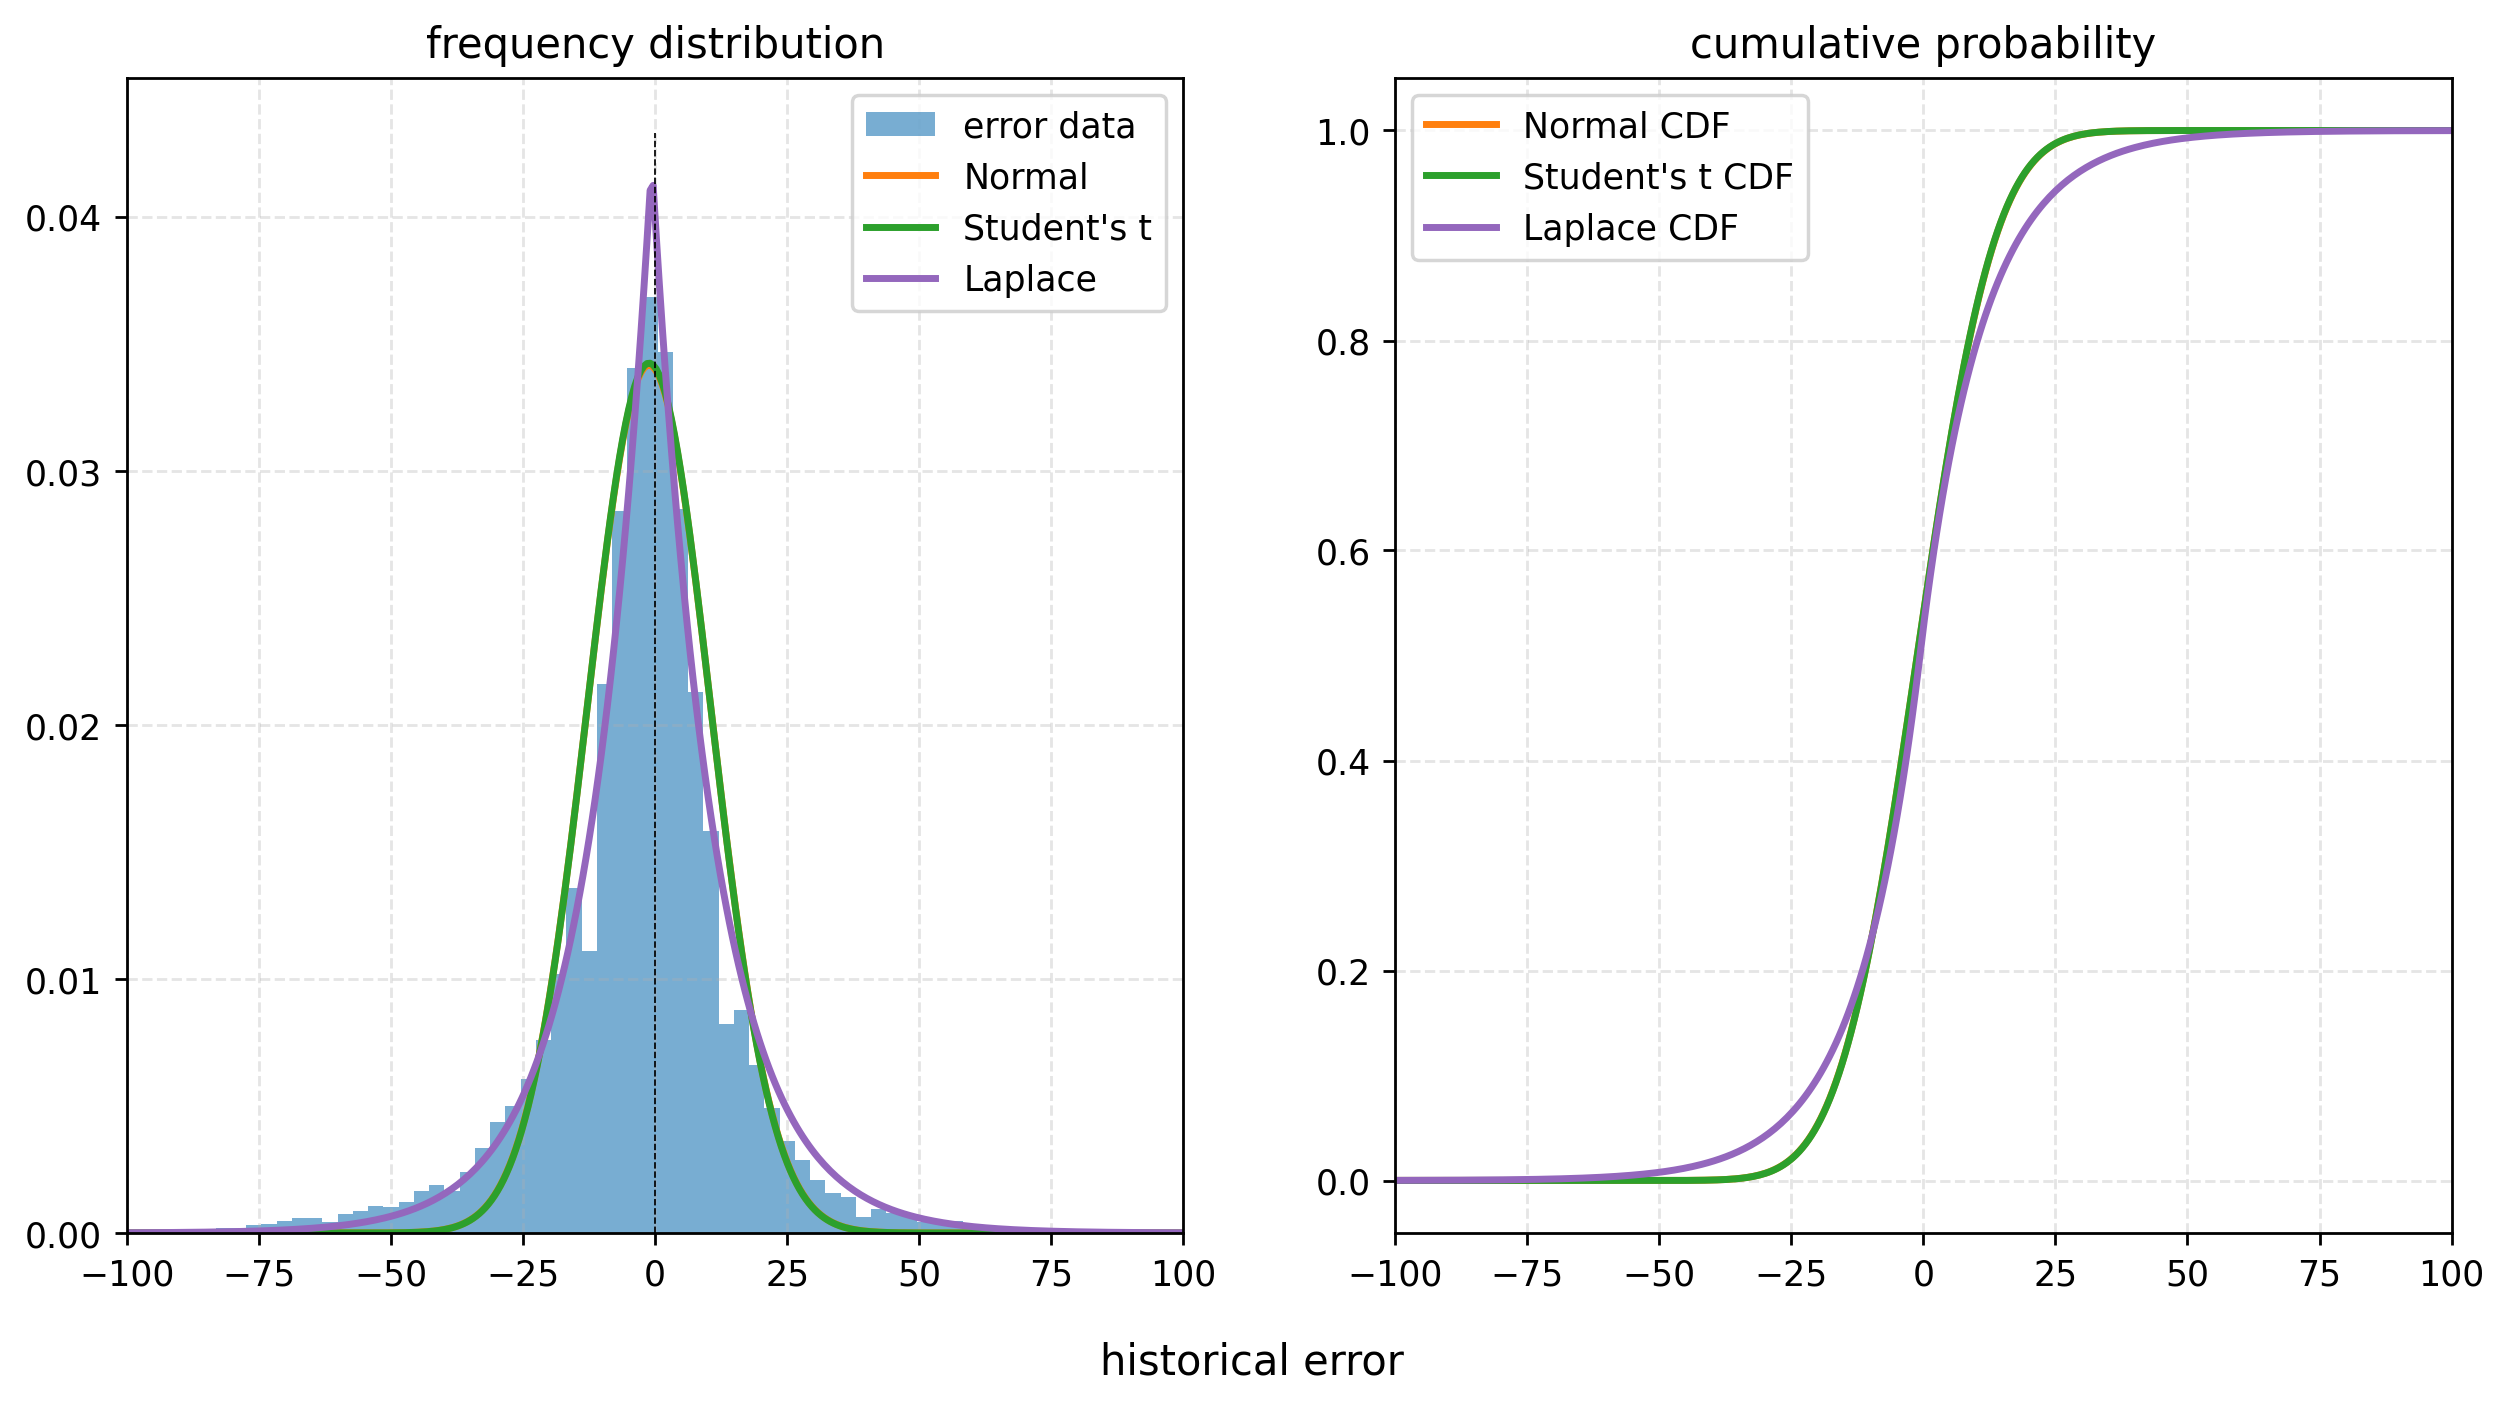

In [12]:
fig, df_extreme_probs = generate_distribution_plots(data_historical_err,
                                  x_label="historical error",
                                  hist_label="error data",
                                  n_bins=200,
                                  x_min=-100,
                                  x_max=100,
                                  lookup_extreme_values=problem_magnitudes(2023, "difference"),
                                 )
df_extreme_probs

Normal distribution parameters:
{'mean': -0.8258451739535284, 'standard deviation': 6.354657040326822}
Student's t distribution parameters:
{'mean': -0.8201483132356021, 'standard deviation': 6.26039445140438, 'degrees of freedom': 10702081.106649347}
Laplace distribution parameters:
{'mean': -0.6425126410175342, 'scale': 6.297288760350895}
ppf_results {'Normal': array([-13.28074411,  11.62905376]), "Student's t": array([-13.09029735,  11.45000073]), 'Laplace': array([-19.50750382,  18.22247853])}


,values,Normal probability,Student's t probability,Laplace probability
0,67.50000,4.692293e-26,8.621957e-27,0.000022
1,40.50000,2.534948e-10,1.367352e-10,0.001619
2,31.61512,7.979125e-07,5.452474e-07,0.006636


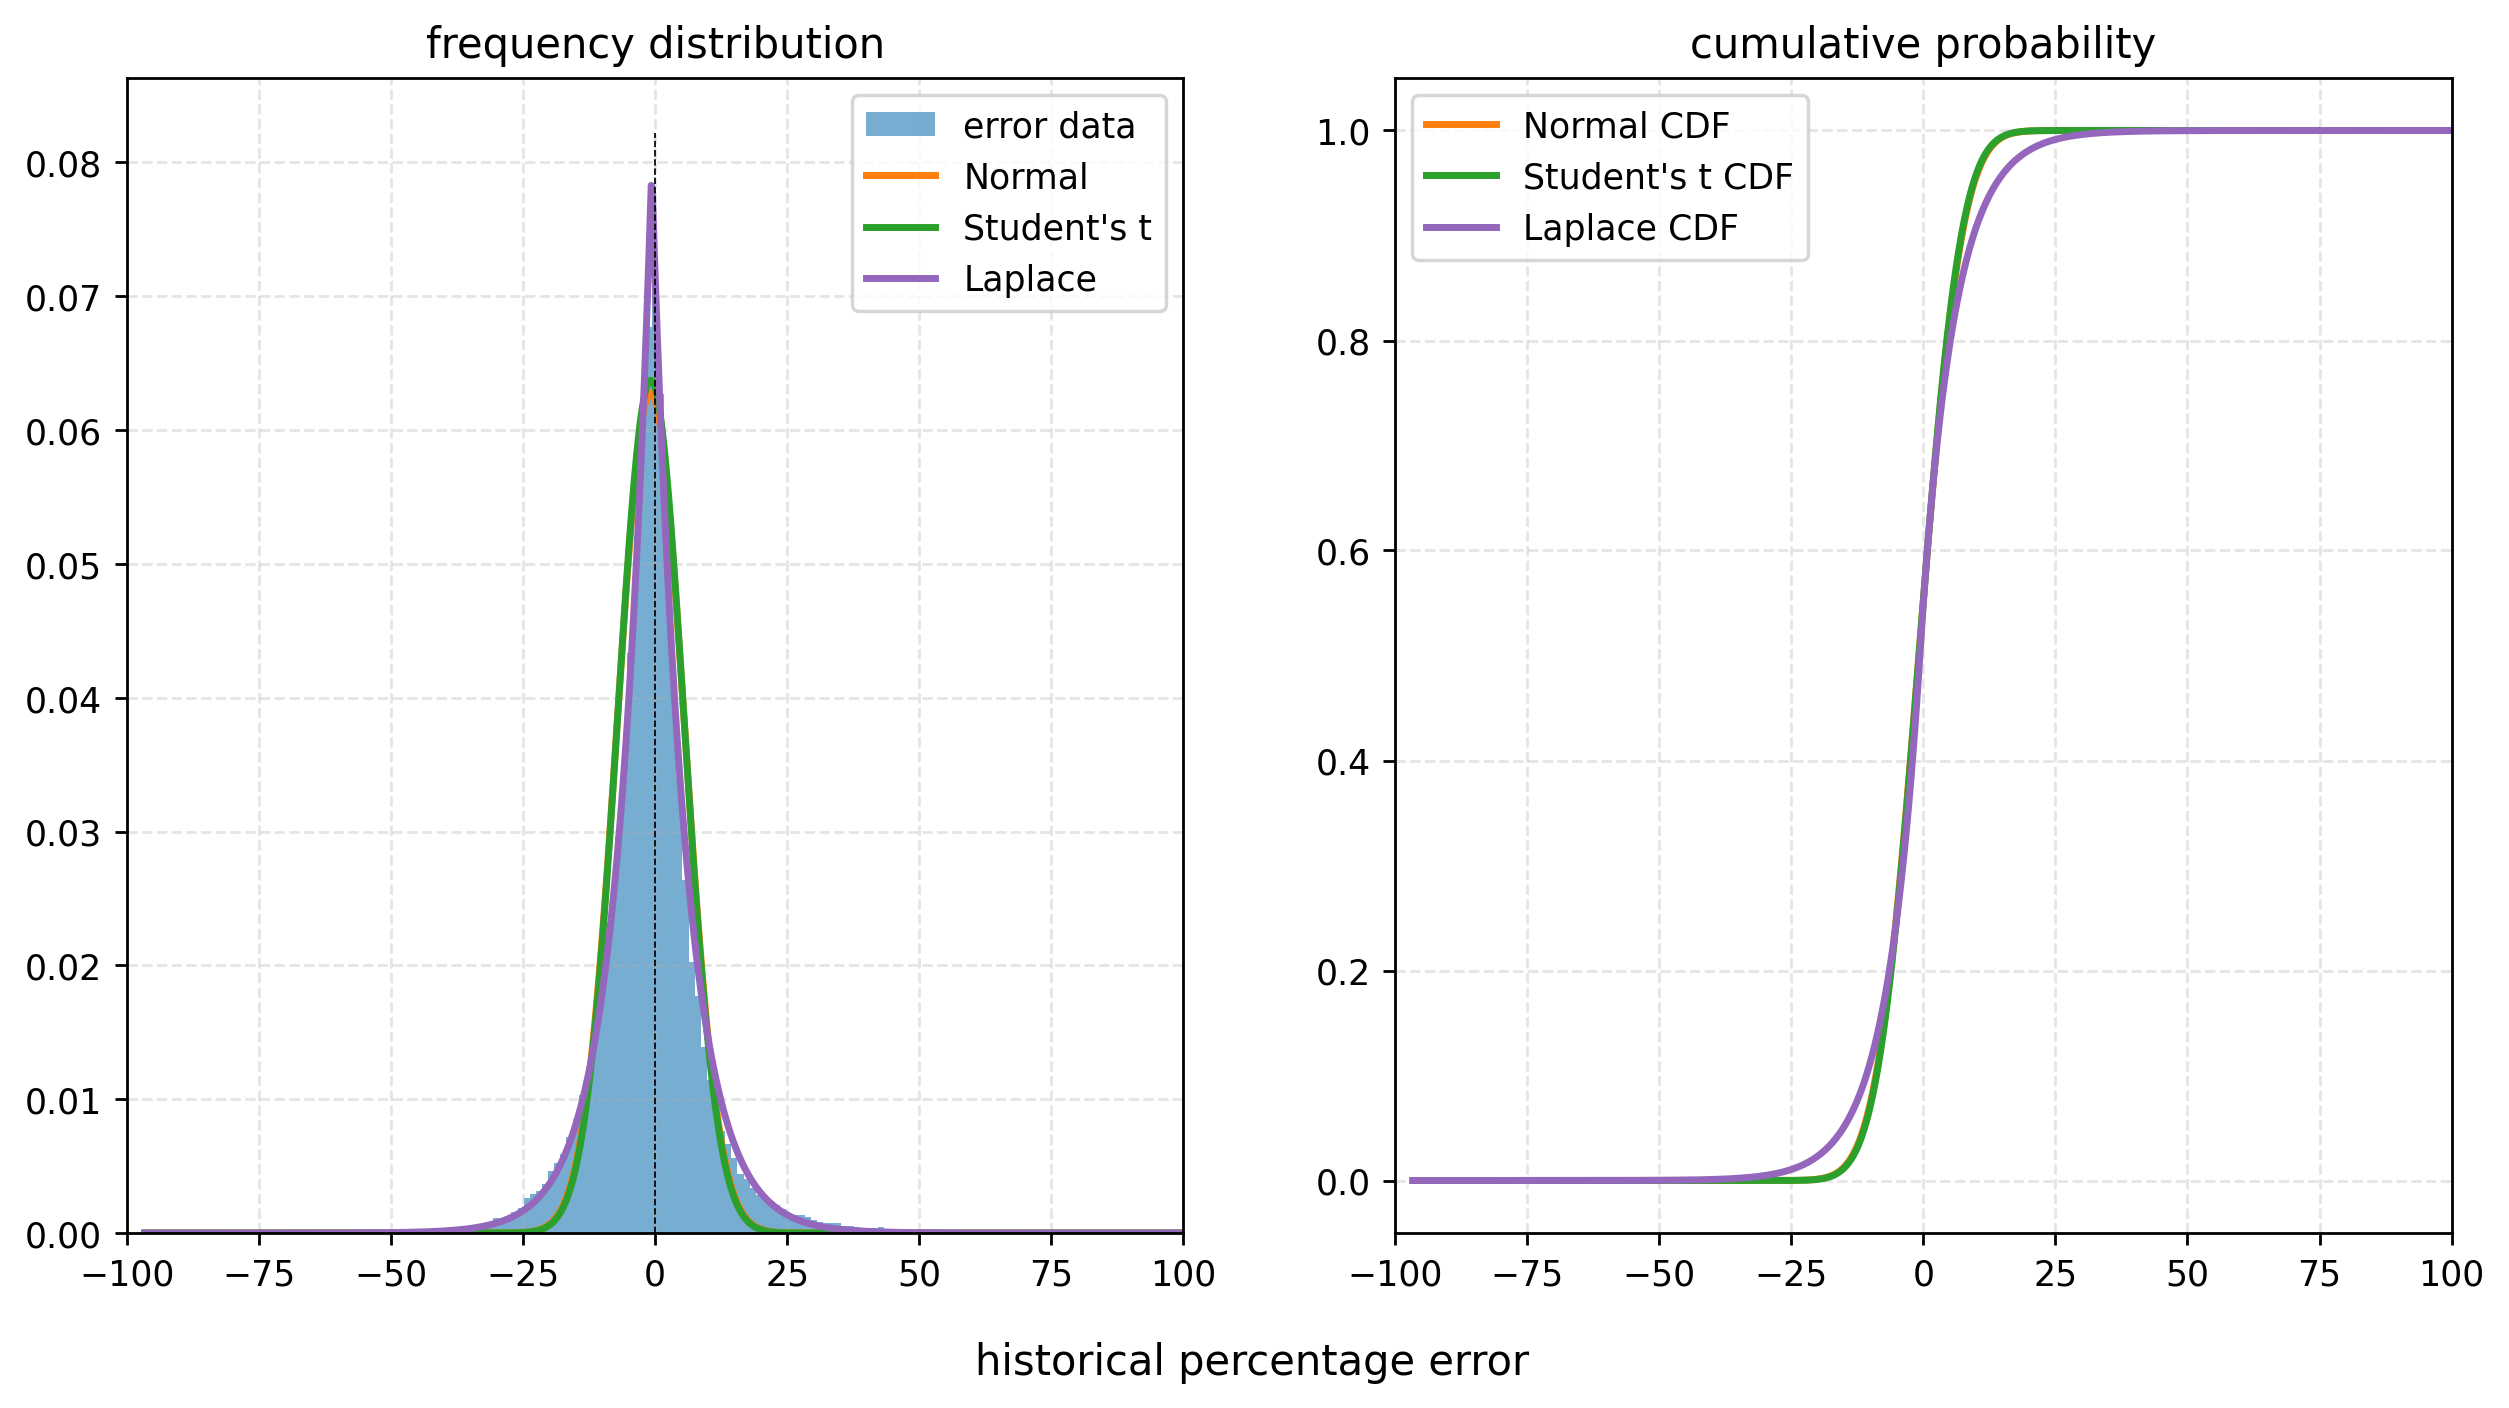

In [13]:
fig, df_extreme_probs = generate_distribution_plots(data_historical_pc_err,
                                  x_label="historical percentage error",
                                  hist_label="error data",
                                  n_bins=200,
                                  x_min=-100,
                                  x_max=100,
                                  lookup_extreme_values=problem_magnitudes(2023, "percentage"),
                                 )
df_extreme_probs

The Laplace distribution seems to fit the historical error data well - especially the percentage error. The normal and Student's distributions essentially overlapped (the degrees of freedom are quite high).

These results give a picture of the probability of an error in the final forecast data, for each time window. This is updated within 30 minutes of the window itself, so these historical forecasts are of limited value for prediction.

The percentage error is also harder to interpret than the actual error, so from here on I'll only follow calculations relating to the actual error.

## Predicting error probability from real data

The above is using the final forecasts downloaded from the website.

Below, I'm calculating the same using actual data, including all downloaded forecasts for every window.

In [14]:
# Example to plot individual plots
summaries_merged_df = get_merged_summaries_with_final_actual_intensities("data", filter="national")

# Get all data so far
dt = datetime(2023,1,1,1,0).astimezone(timezone.utc)
n_days = (datetime.today().astimezone(timezone.utc) - dt).days
dates = get_dates(summaries_merged_df, num_days=n_days, start_date=dt)
df_summary = summaries_merged_df.loc[dates].copy()
df_err, df_pc_err = _error_and_percentage_error(df_summary)

# Only pre-timepoint forecasts
df_err = df_err[[c for c in df_err.columns if float(c) >= 0.0]]
df_pc_err = df_pc_err[[c for c in df_pc_err.columns if float(c) >= 0.0]]

# Aggregate all forecasts and timepoints into one row per year
result_pc_err = _aggregate_per(df_pc_err, "year")
df_pc_err_year = result_pc_err.T.copy()
result_err = _aggregate_per(df_err, "year")
df_err_year = result_err.T.copy()

print(f"half-hour timepoints: {len(dates)}; forecasts: {len(result_err.T)}")
result_err

half-hour timepoints: 2672; forecasts: 172307


,0.0_49,0.0_50,0.0_51,0.0_52,0.0_53,0.0_54,0.0_55,0.0_56,0.0_57,0.0_58,...,47.5_2564,47.5_2565,47.5_2566,47.5_2567,47.5_2568,47.5_2569,47.5_2570,47.5_2571,47.5_2575,47.5_2576
2023,-8.0,-9.0,-6.0,-7.0,-6.0,-3.0,1.0,-3.0,-9.0,-20.0,...,-20.0,-17.0,-25.0,-19.0,14.0,18.0,18.0,10.0,-18.0,-24.0


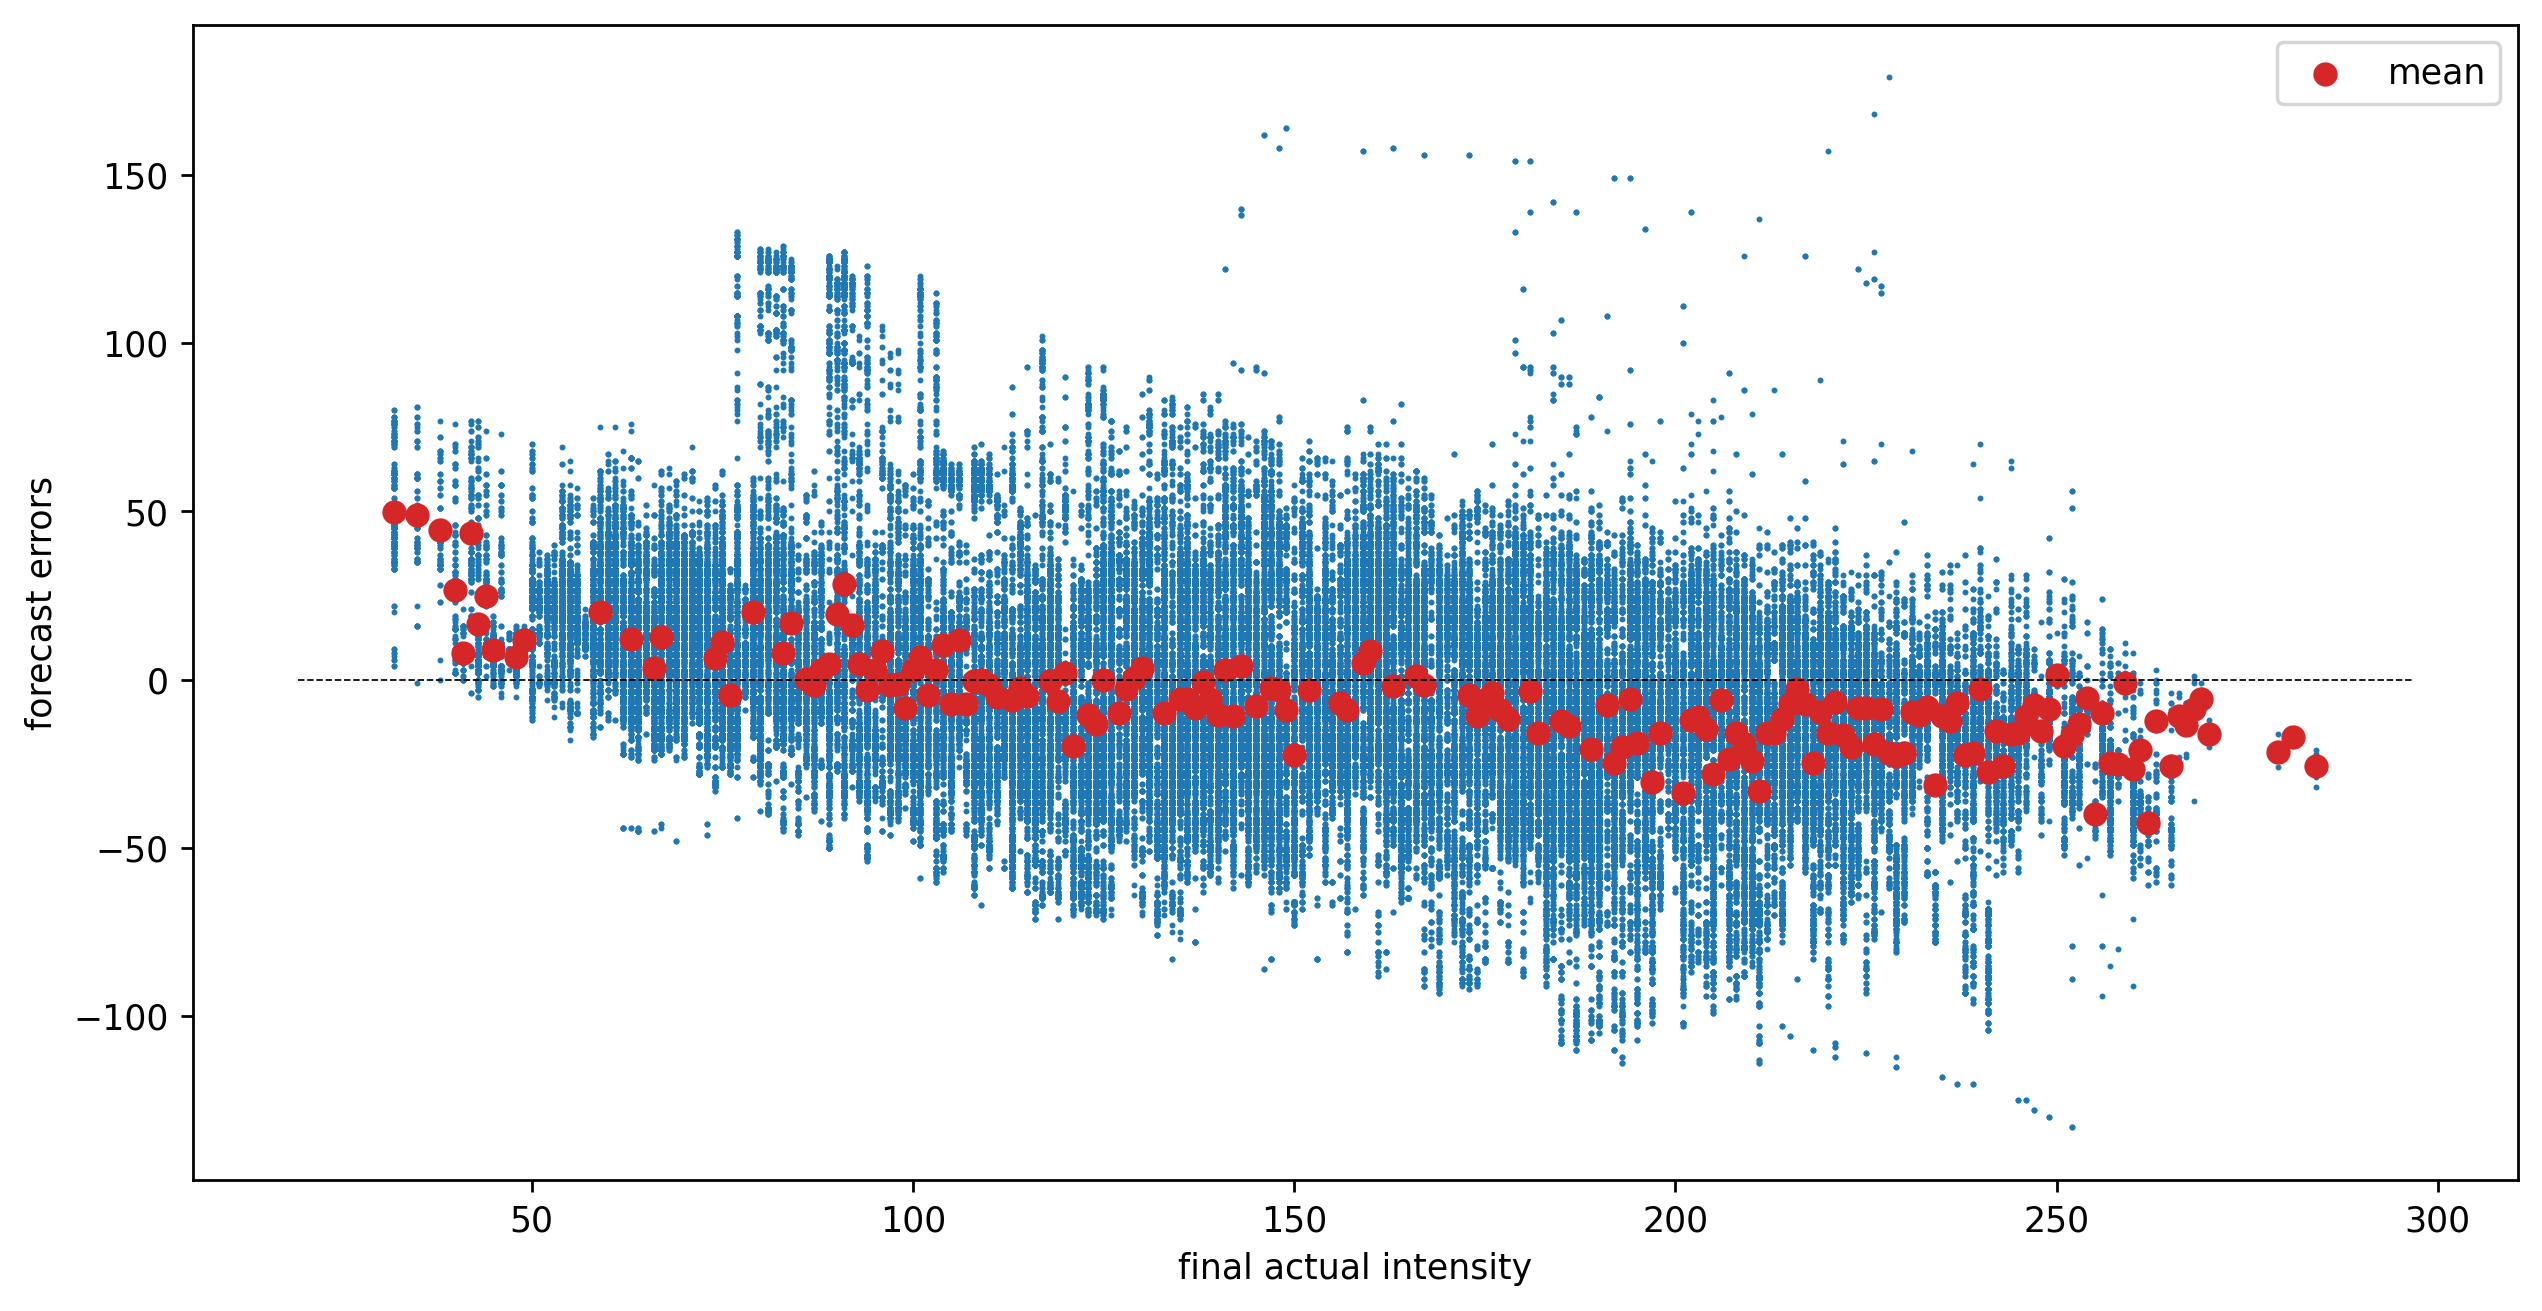

r=-0.16660095519447024


In [15]:
df_actual = df_summary[["intensity.actual.final"]]
cols = df_actual.columns
df_actual.columns = cols.droplevel(1)

data = pd.concat([df_actual, df_err], axis=1)

x_col_name = "intensity.actual.final"

marker_properties_raw_data = {
    'color': 'tab:blue',
    'marker': 'o',
    's': 0.5,  # size
#     'alpha': 0.1
}

# Set up means
data_dict = defaultdict(list)

# Calculate the mean of the remaining columns
mean_values = data.iloc[:, 1:].mean(axis=1)

unique_keys = sorted(data[x_col_name].unique())

# Gather all the data from the other columns for each key
for ix, row in data.iterrows():
    key = row[x_col_name]
    data_dict[key].append(row[1:].mean())

# Calculate the overall mean for each key
mean_dict = {key: np.mean(values) for key, values in data_dict.items()}

# Plot both raw data and means

fig, ax = plt.subplots()
for column in data.columns[1:]:
    ax.scatter(data[x_col_name], data[column], **marker_properties_raw_data)
    
ax.scatter(list(mean_dict.keys()), list(mean_dict.values()), color="tab:red", label="mean")

ax.hlines(
    0.0,
    ax.get_xlim()[0],
    ax.get_xlim()[-1],
    color="k",
    linestyle="--",
    linewidth=0.5,
)
ax.legend()
ax.set_xlabel("final actual intensity")
ax.set_ylabel("forecast errors")
plt.show()

pearson_r = data[x_col_name].corr(data[column])
print(f"r={pearson_r}")

There is a weakly negative relationship between forecast error and the final recorded CI.

In [16]:
# Actual error values
stats_df_err_abs = df_err_year.abs().agg(["count", "mean", "median", "std", "sem"], axis=0).T
stats_df_err = df_err_year.agg(["count", "mean", "median", "std", "sem"], axis=0).T
stats_df_err_abs, stats_df_err

(         count       mean  median        std       sem
 2023  172307.0  23.848857    20.0  19.423144  0.046792,
          count      mean  median        std       sem
 2023  172307.0 -4.405097    -5.0  30.440513  0.073333)

In [17]:
# Percentage error
stats_df_abs = df_pc_err_year.abs().agg(["count", "mean", "median", "std", "sem"], axis=0).T
stats_df = df_pc_err_year.agg(["count", "mean", "median", "std", "sem"], axis=0).T
stats_df_abs, stats_df

(         count     mean     median        std       sem
 2023  172307.0  18.7157  13.978495  18.807508  0.045309,
          count      mean    median        std       sem
 2023  172307.0  0.683079 -3.314917  26.524238  0.063899)

0 excluded outliers, 0 nans, leaving 172307 data points
0 excluded outliers, 0 nans, leaving 172307 data points
(172307,) (172307,)


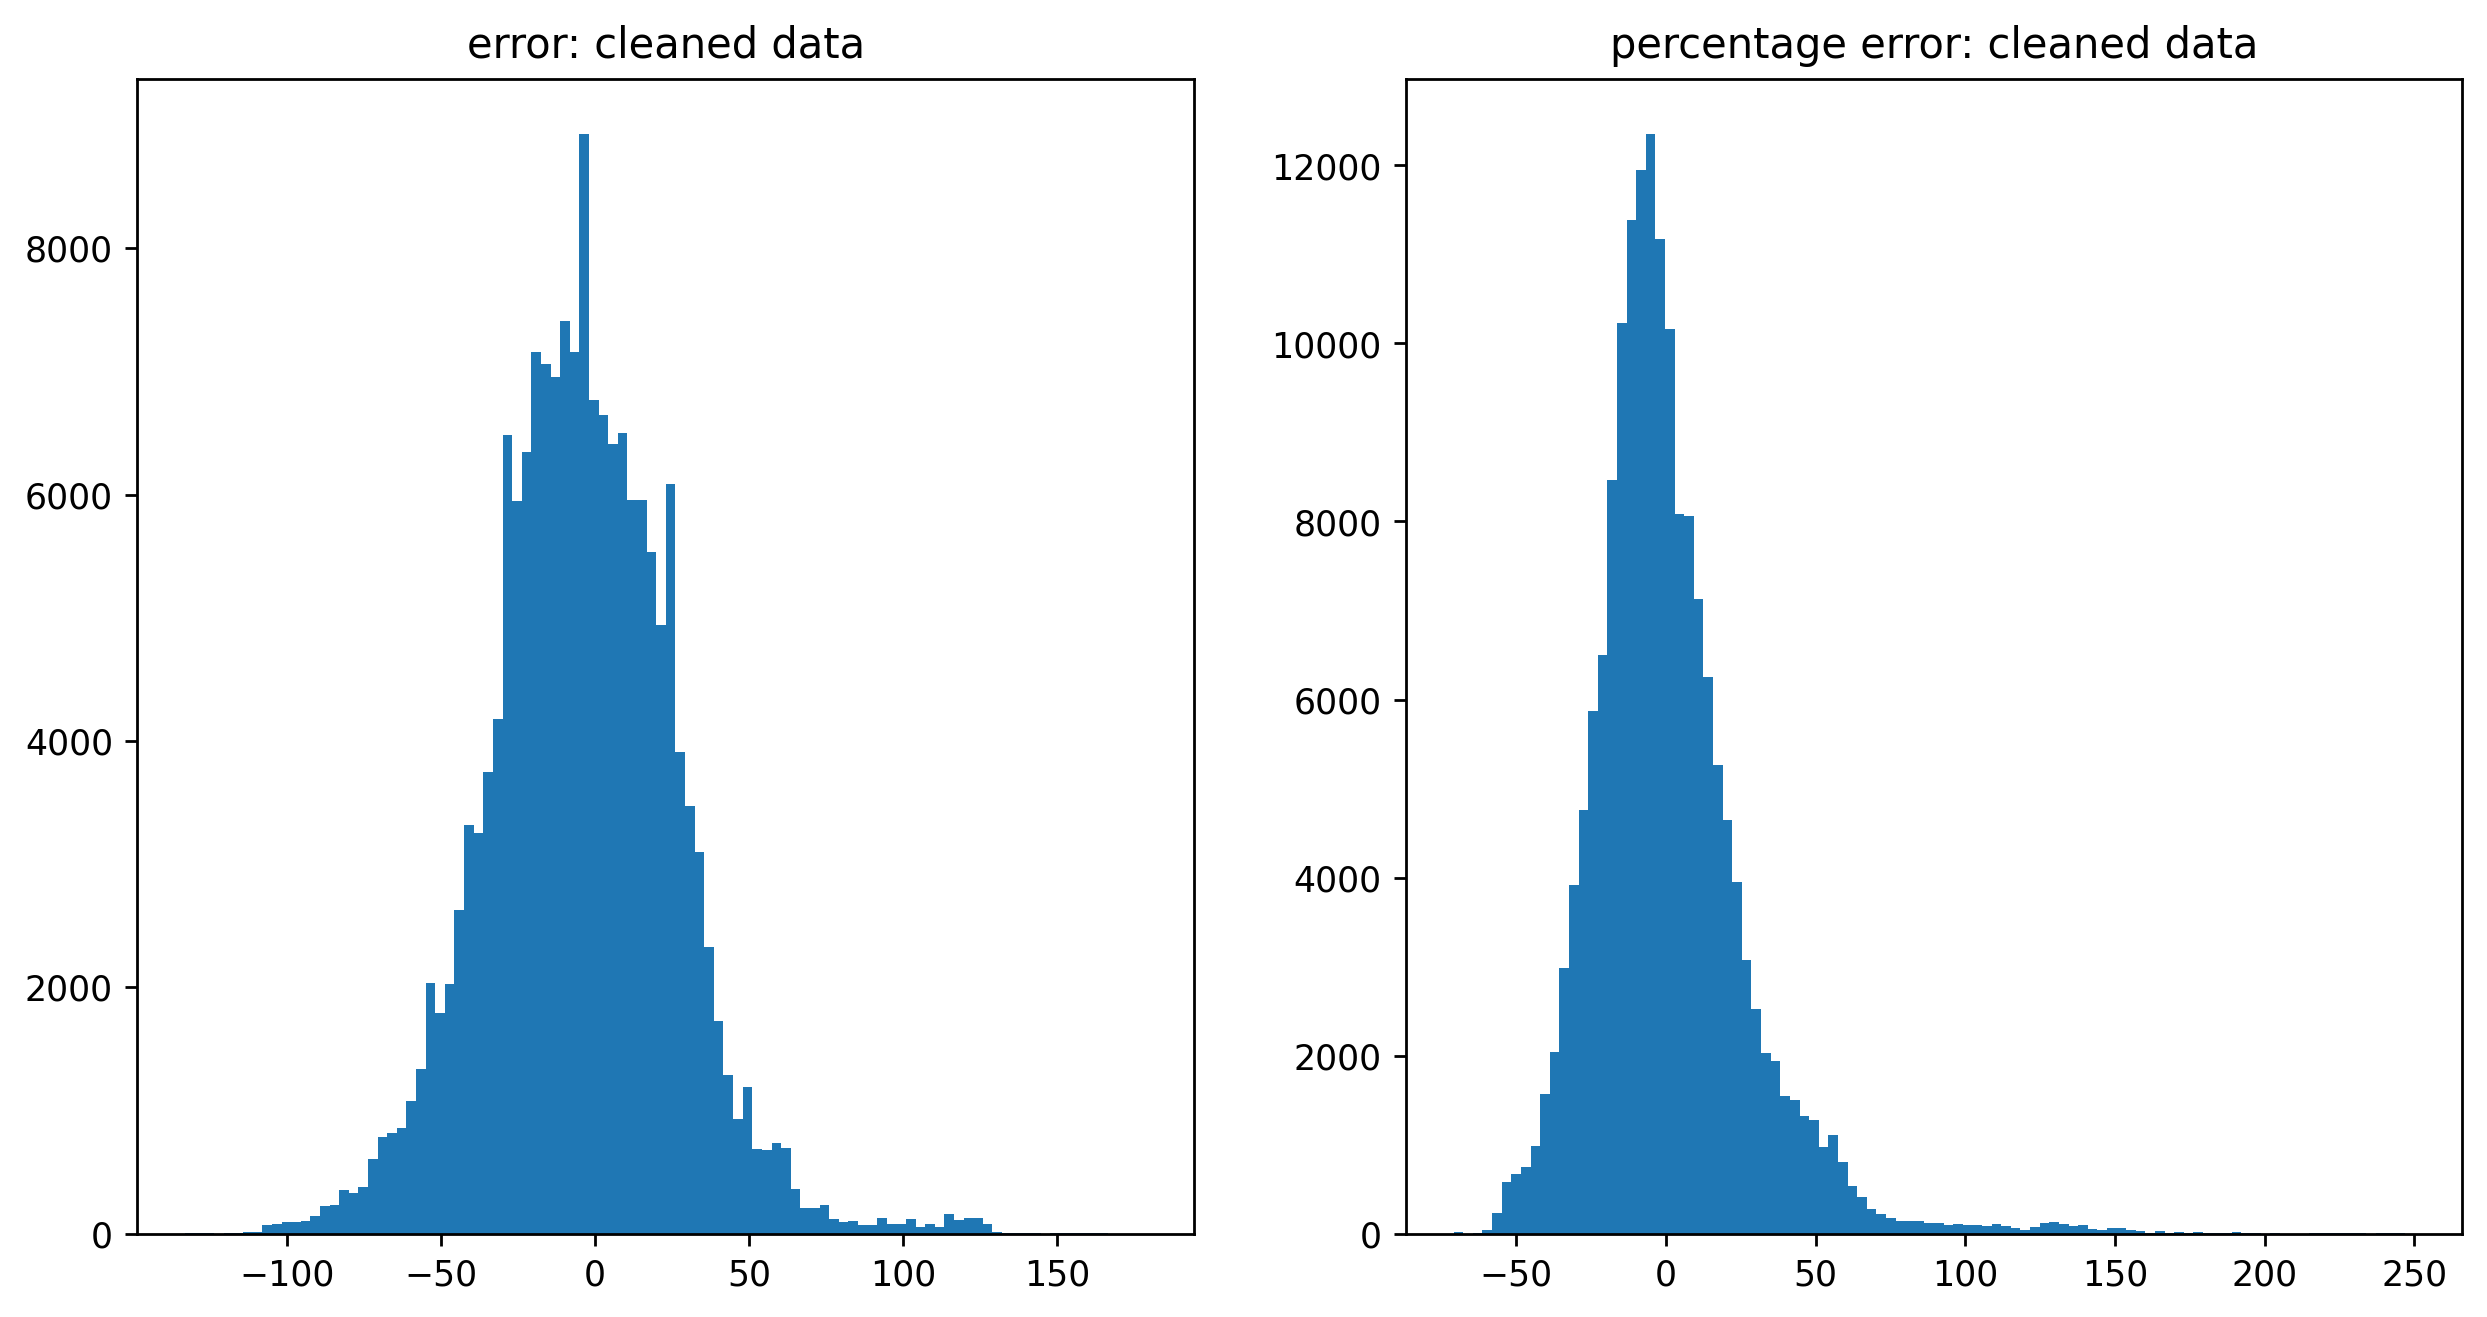

In [18]:
# Clean up as above
data_forecast_err = cleanup(df_err_year, 2023, max_cutoff=1000)
data_forecast_pc_err = cleanup(df_pc_err_year, 2023, max_cutoff=1000)

print(data_forecast_err.shape, data_forecast_pc_err.shape)

fig, ax = plt.subplots(1,2)
ax[0].hist(data_forecast_err, bins=100)
ax[0].set_title(f"error: cleaned data")
ax[1].hist(data_forecast_pc_err, bins=100)
ax[1].set_title(f"percentage error: cleaned data")
plt.show()

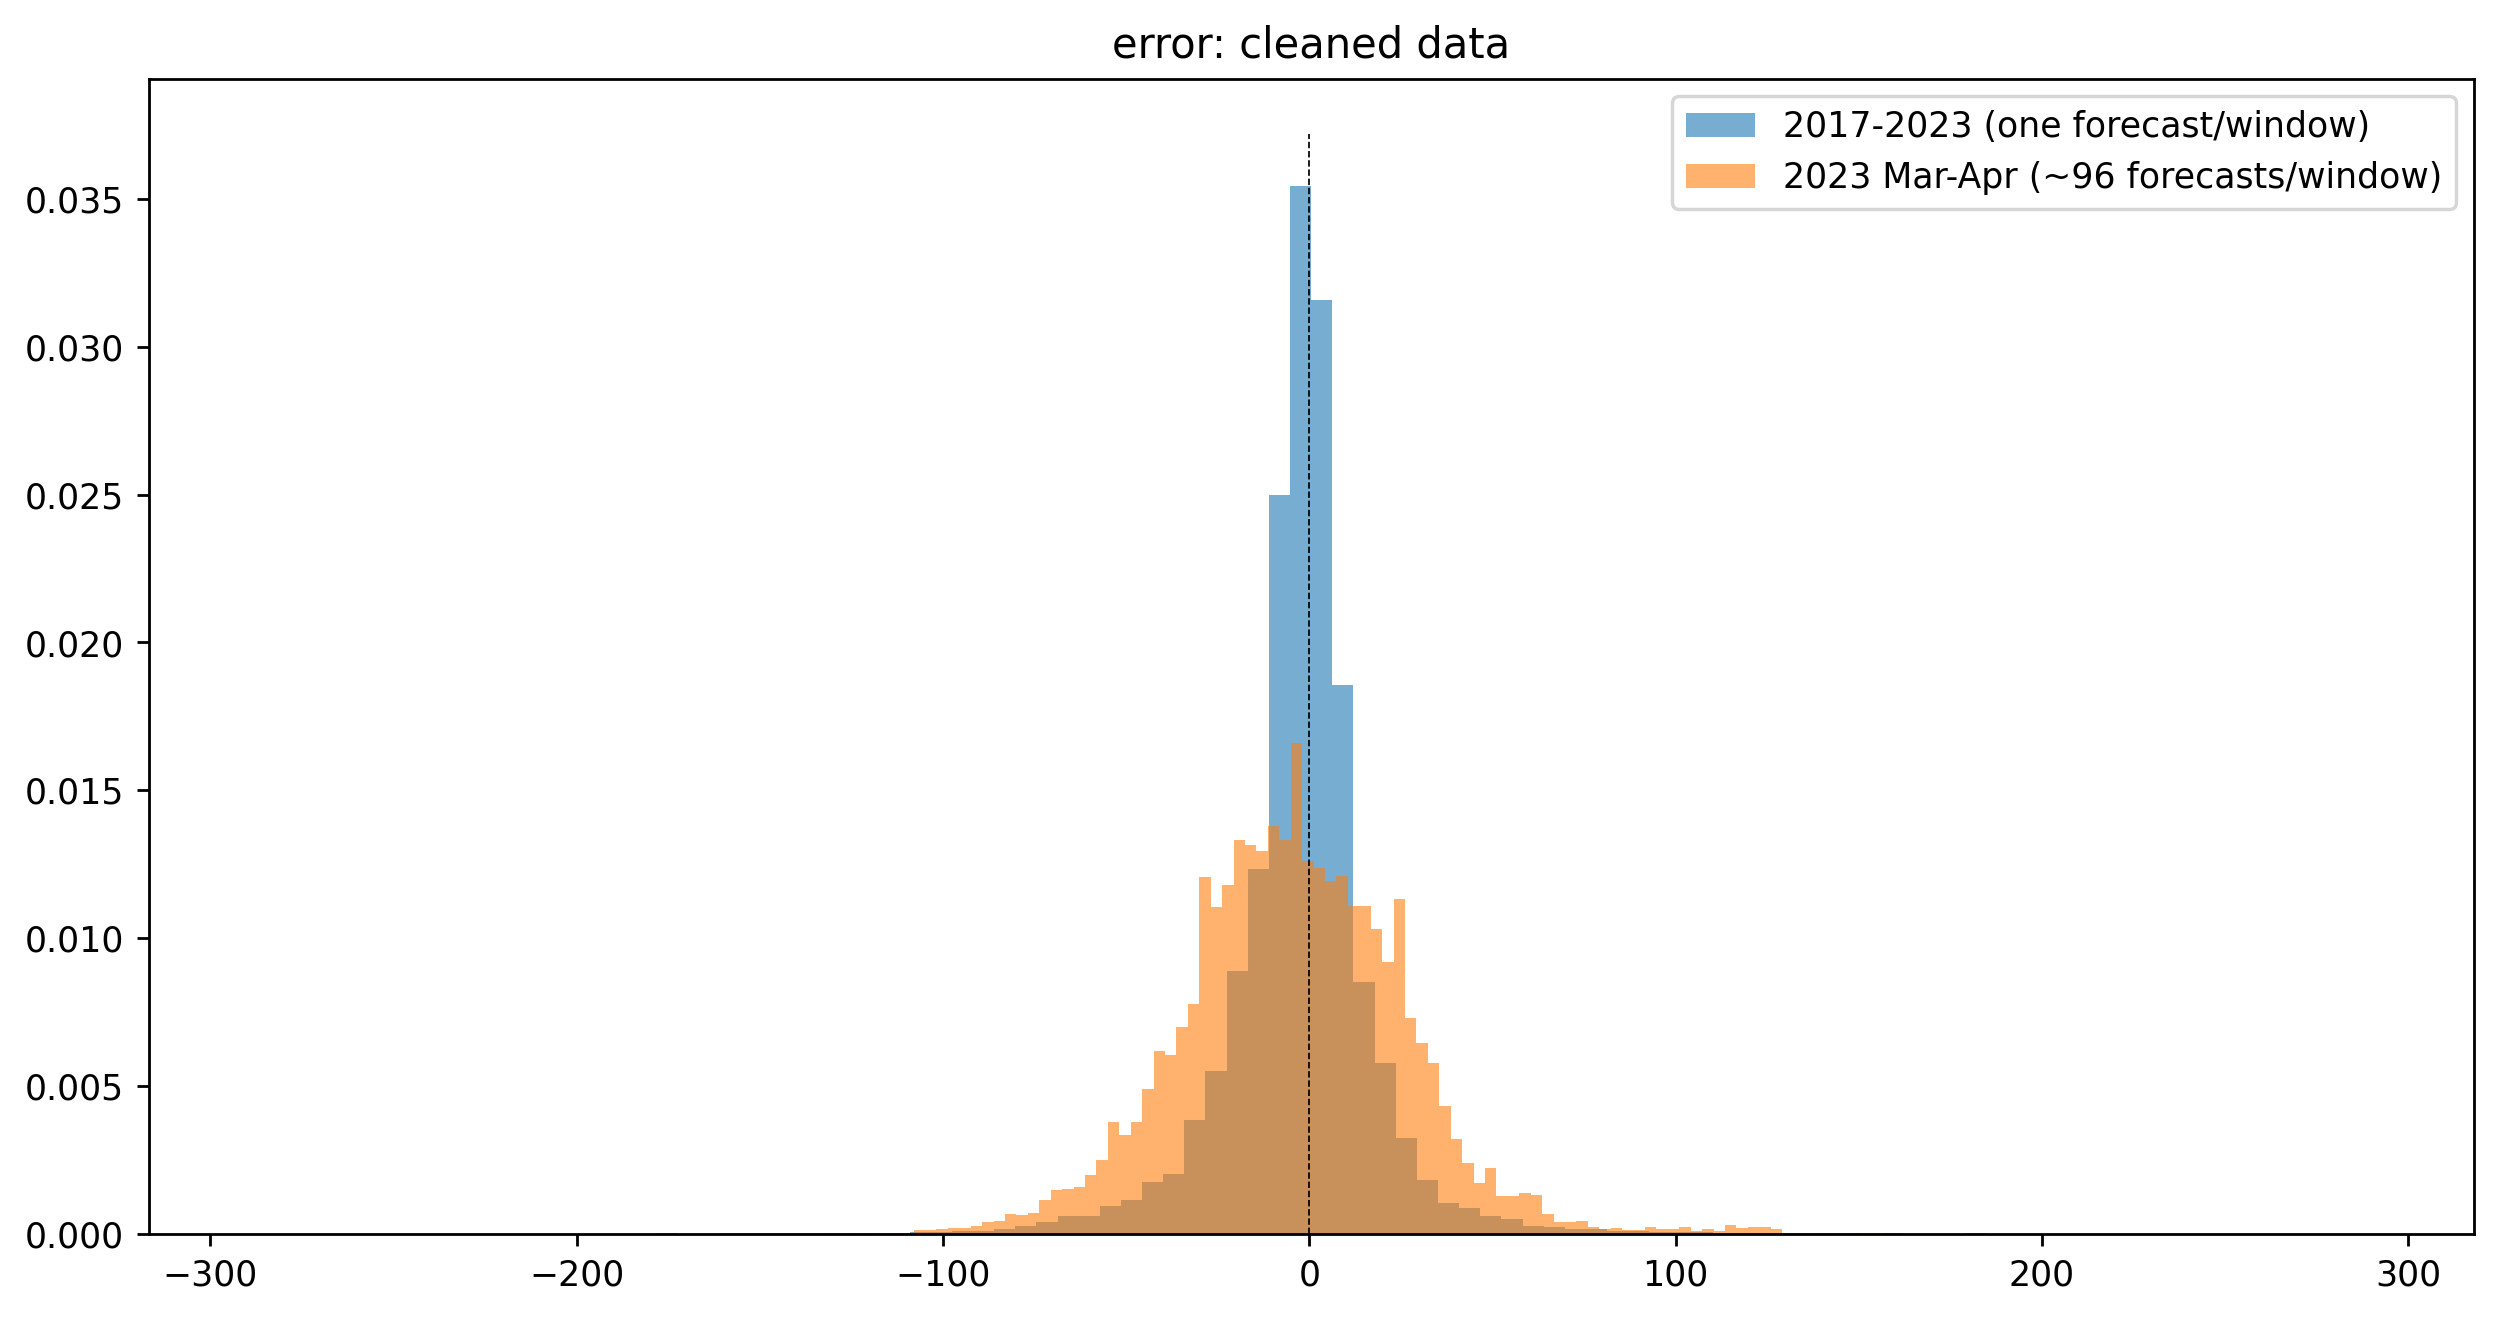

In [19]:
# Compare the two distributions (error)
n_bins=100
fig, ax = plt.subplots(1,1)
ax.hist(data_historical_err, bins=n_bins, alpha=0.6, density=True, label="2017-2023 (one forecast/window)")
ax.hist(data_forecast_err, bins=n_bins, alpha=0.6, density=True, label="2023 Mar-Apr (~96 forecasts/window)")
ax.set_title("error: cleaned data")
ax.vlines(0, *ax.get_ylim(), color="k", linestyle="--", linewidth=0.5)
l = ax.legend()
save_figure(fig, "./charts", "ci_error_histograms_compared.png")

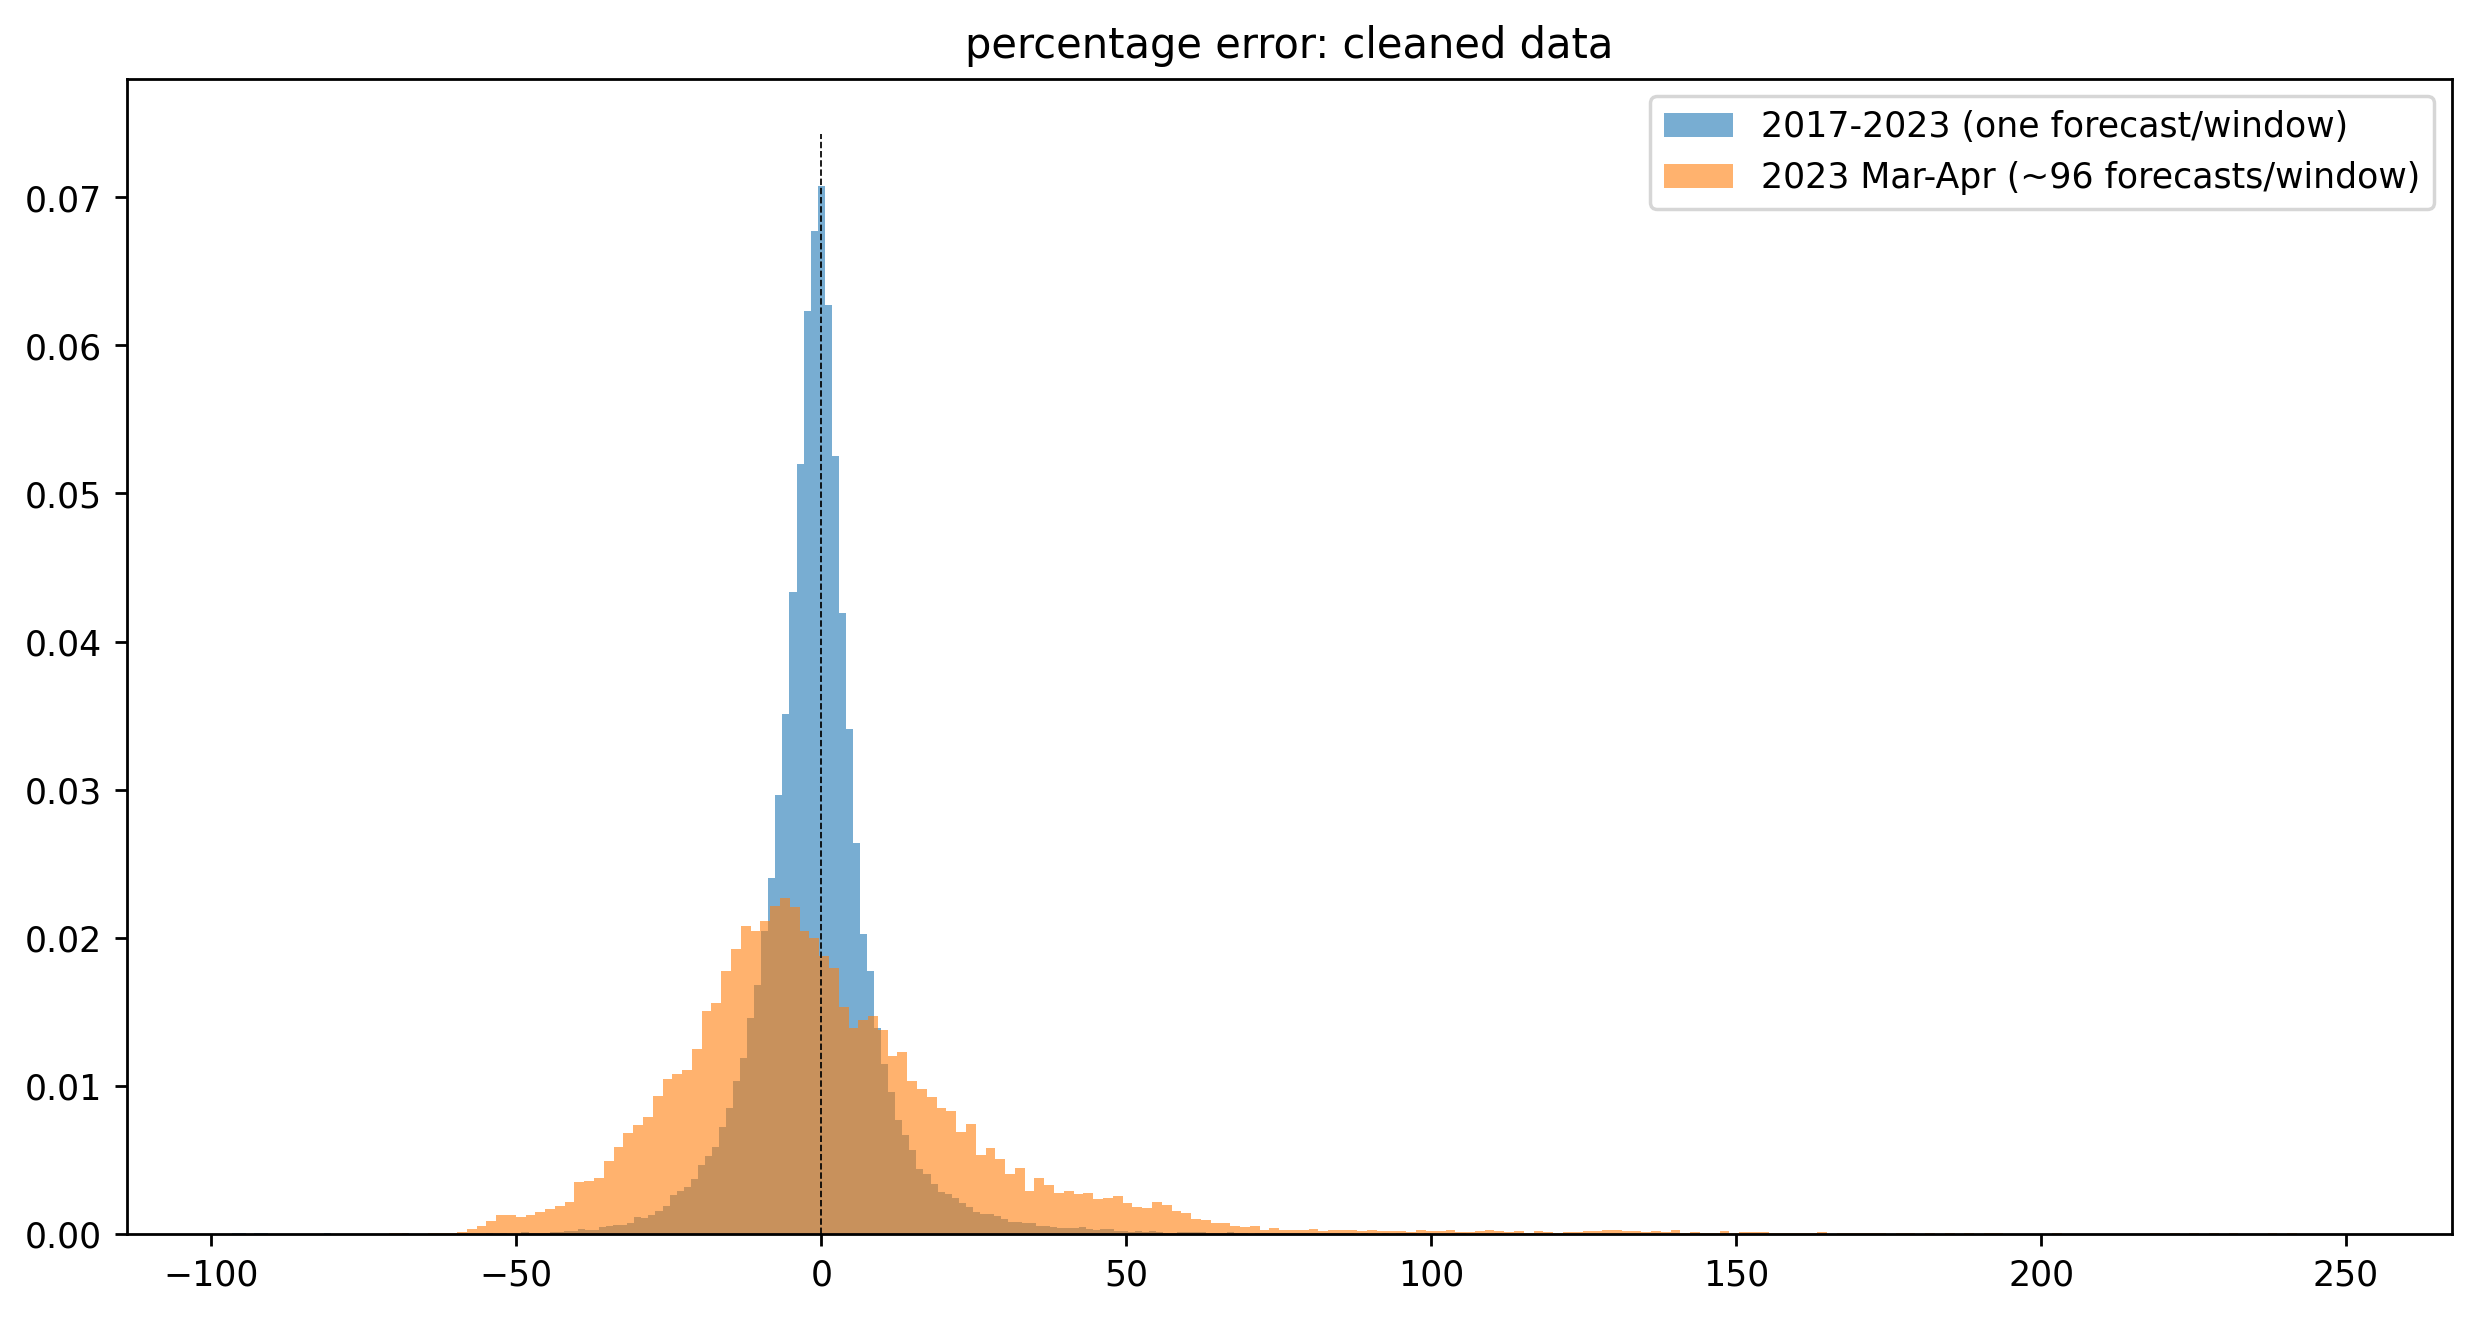

In [20]:
# Compare the two distributions (percentage error)
n_bins=200
fig, ax = plt.subplots(1,1)
ax.hist(data_historical_pc_err, bins=n_bins, alpha=0.6, density=True, label="2017-2023 (one forecast/window)")
ax.hist(data_forecast_pc_err, bins=n_bins, alpha=0.6, density=True, label="2023 Mar-Apr (~96 forecasts/window)")
ax.set_title("percentage error: cleaned data")
ax.vlines(0, *ax.get_ylim(), color="k", linestyle="--", linewidth=0.5)
l = ax.legend()
save_figure(fig, "./charts", "ci_percentage_error_histograms_compared.png")

Normal distribution parameters:
{'mean': -4.679303287569809, 'standard deviation': 28.284513600797613}
Student's t distribution parameters:
{'mean': -4.691143296194554, 'standard deviation': 28.28296308339635, 'degrees of freedom': 1384358.1251316415}
Laplace distribution parameters:
{'mean': -4.824283399633023, 'scale': 28.551922397043725}
ppf_results {'Normal': array([-60.11593127,  50.75732469]), "Student's t": array([-60.12478078,  50.74249419]), 'Laplace': array([-90.3581988,  80.709632 ])}


,values,Normal probability,Student's t probability,Laplace probability
0,90,0.001686,0.001687,0.043372
1,80,0.005250,0.005251,0.061562
2,70,0.014602,0.014603,0.087382
3,60,0.036346,0.036349,0.124031
4,50,0.081149,0.081154,0.176050
5,40,0.162970,0.162977,0.249886
6,30,0.295419,0.295427,0.354690
7,20,0.485483,0.485490,0.503450


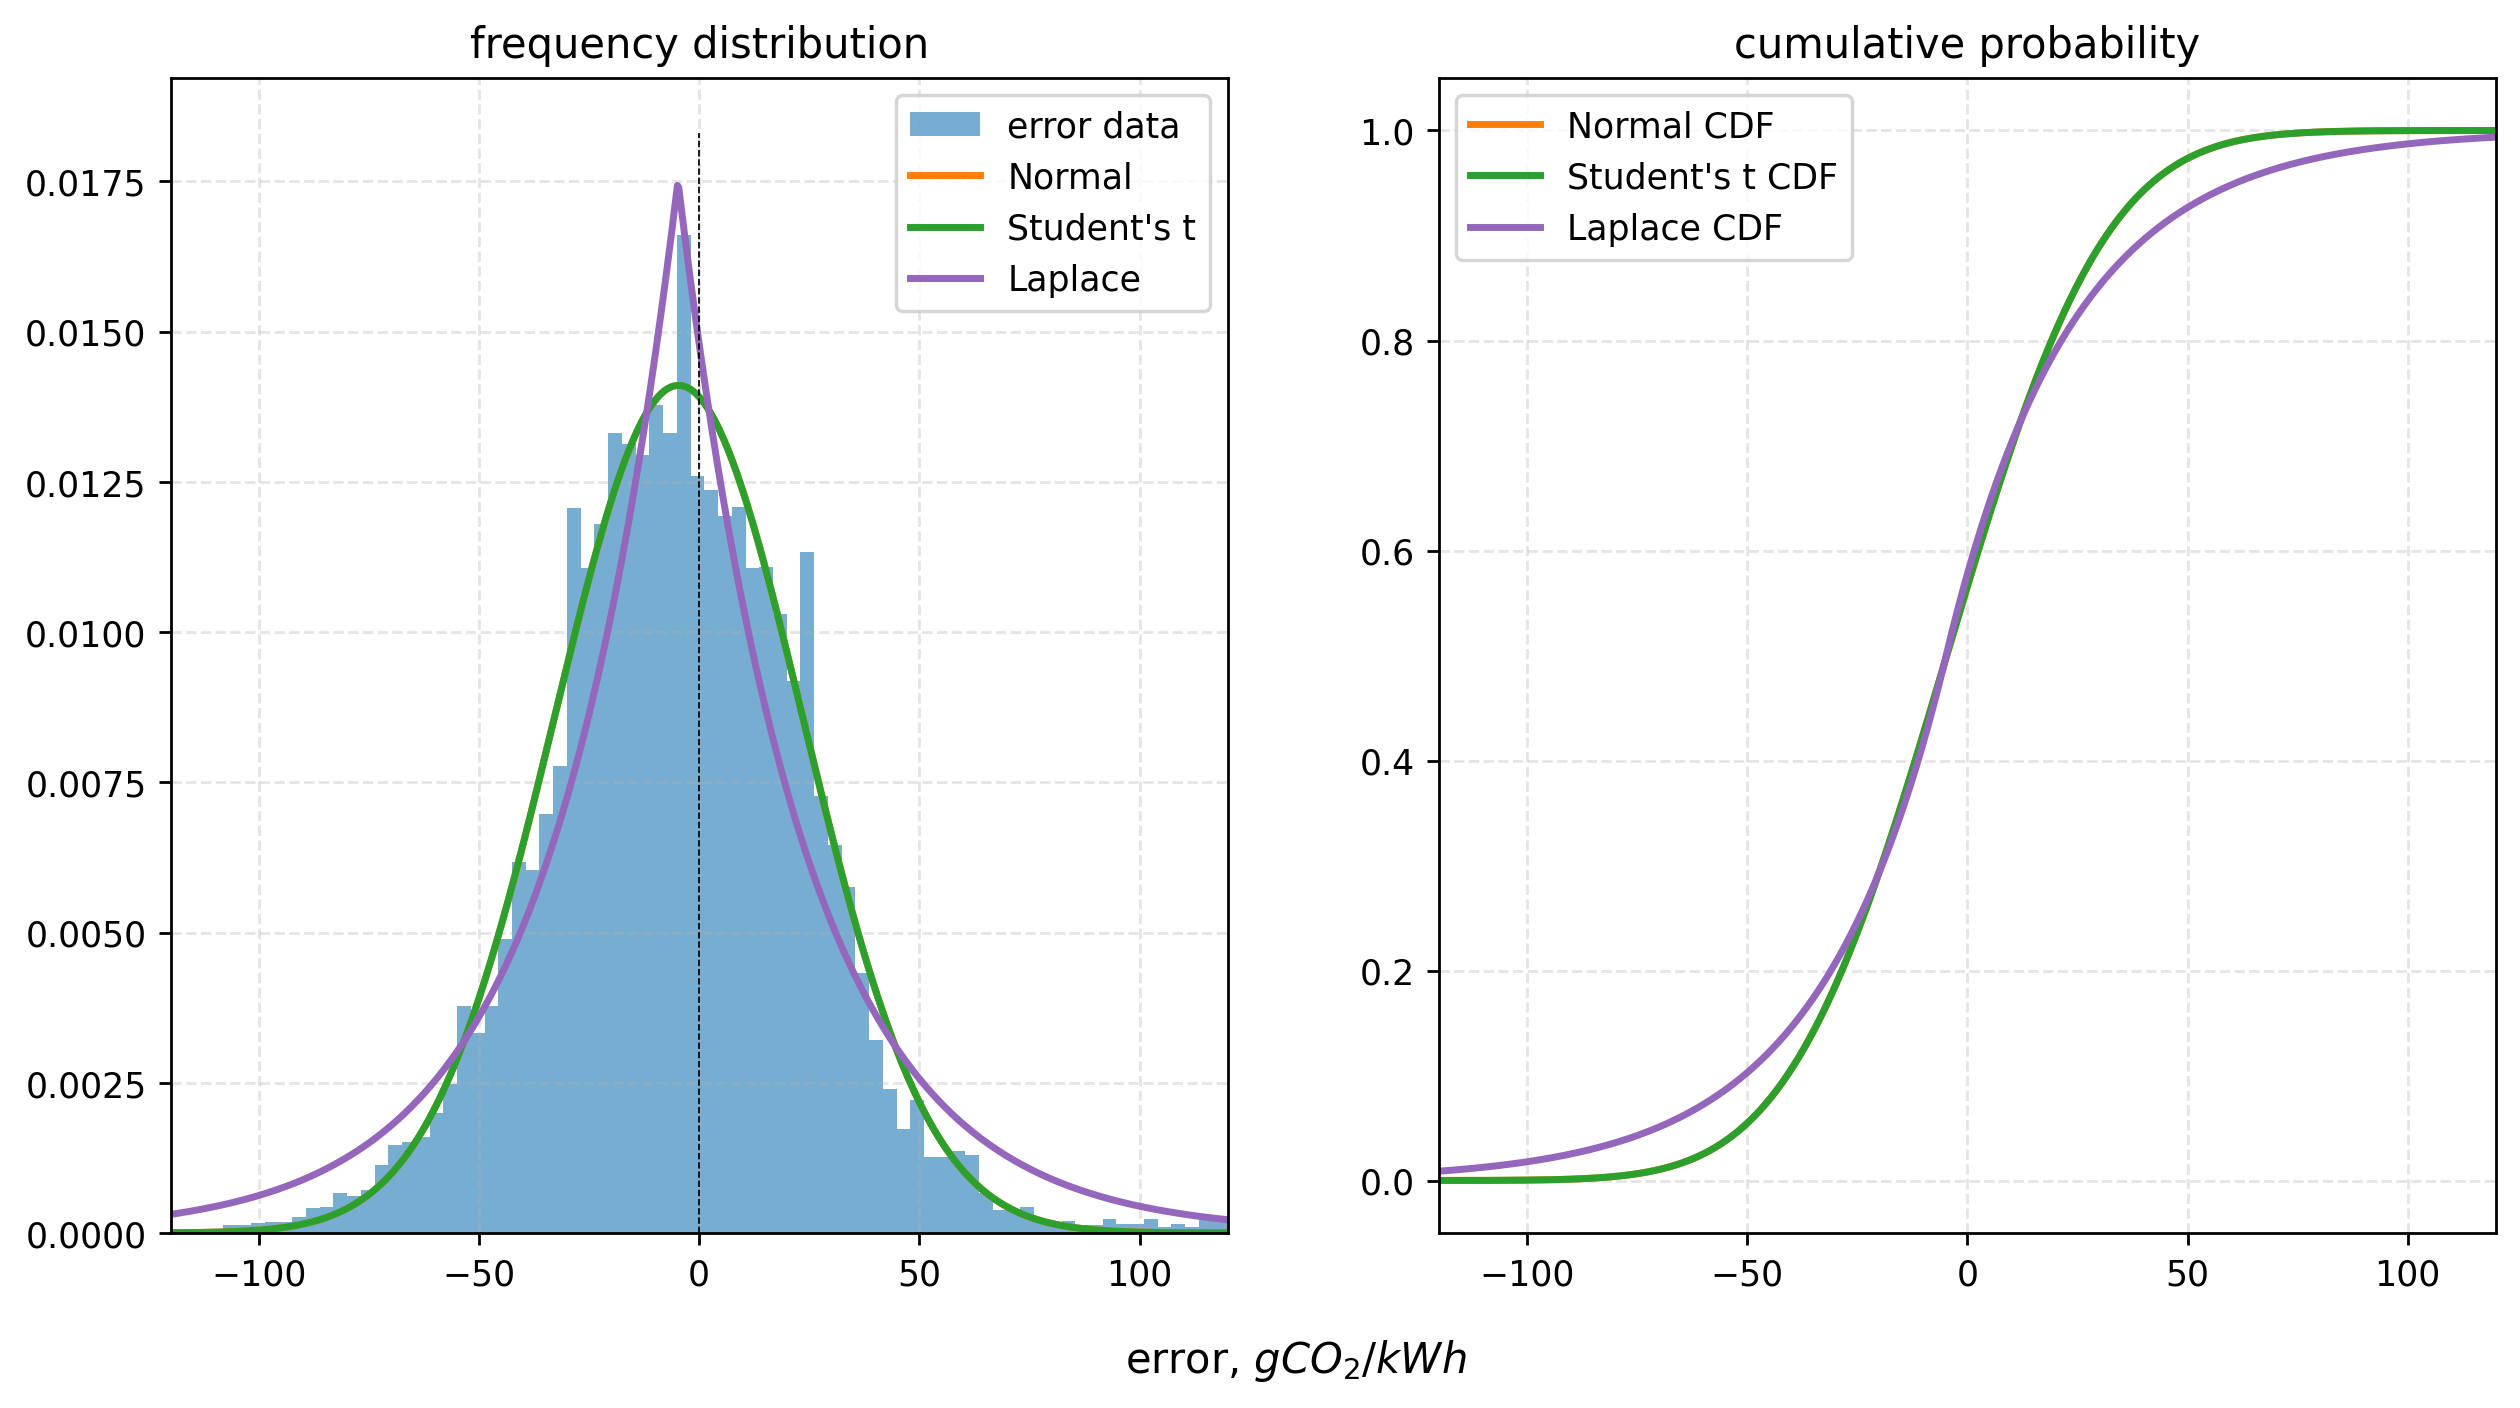

In [23]:
fig, df_extreme_probs = generate_distribution_plots(data_forecast_err,
                                  x_label="error, $gCO_2/kWh$",
                                  hist_label="error data",
                                  n_bins=100,
                                  x_min=-120,
                                  x_max=120,
                                  lookup_extreme_values=[90, 80, 70, 60, 50, 40, 30, 20],
                                 )
# problem_magnitudes(2023, "difference")

save_figure(fig, "./charts", "ci_forecast_error_distribution.png")

df_extreme_probs

Nevertheless, assuming such a distribution holds, and assuming the error is independent of the actual CI value, the chance of any `very low` forecast eventually materialising as a `moderate` or greater index is about $3.8\%$. Similarly:
| index range       | chance (Laplacian) |
|-------------------|------------|
| very low - moderate (or greater) | 3.81%      |
| low - high (or greater) | 14.4%     |
| moderate - very high (or greater) | 22.4%    |

And for the more conservative case, the difference between the midpoint of each index range and the boundary with the next highest level...

Normal distribution parameters:
{'mean': -4.679303287569809, 'standard deviation': 28.284513600797613}
Student's t distribution parameters:
{'mean': -4.691143296194554, 'standard deviation': 28.28296308339635, 'degrees of freedom': 1384358.1251316415}
Laplace distribution parameters:
{'mean': -4.824283399633023, 'scale': 28.551922397043725}
ppf_results {'Normal': array([-60.11593127,  50.75732469]), "Student's t": array([-60.12478078,  50.74249419]), 'Laplace': array([-90.3581988,  80.709632 ])}


,values,Normal probability,Student's t probability,Laplace probability
0,20.5,0.474640,0.474647,0.494710
1,40.5,0.157775,0.157781,0.245548
2,40.5,0.157775,0.157781,0.245548
3,46.0,0.108607,0.108612,0.202525


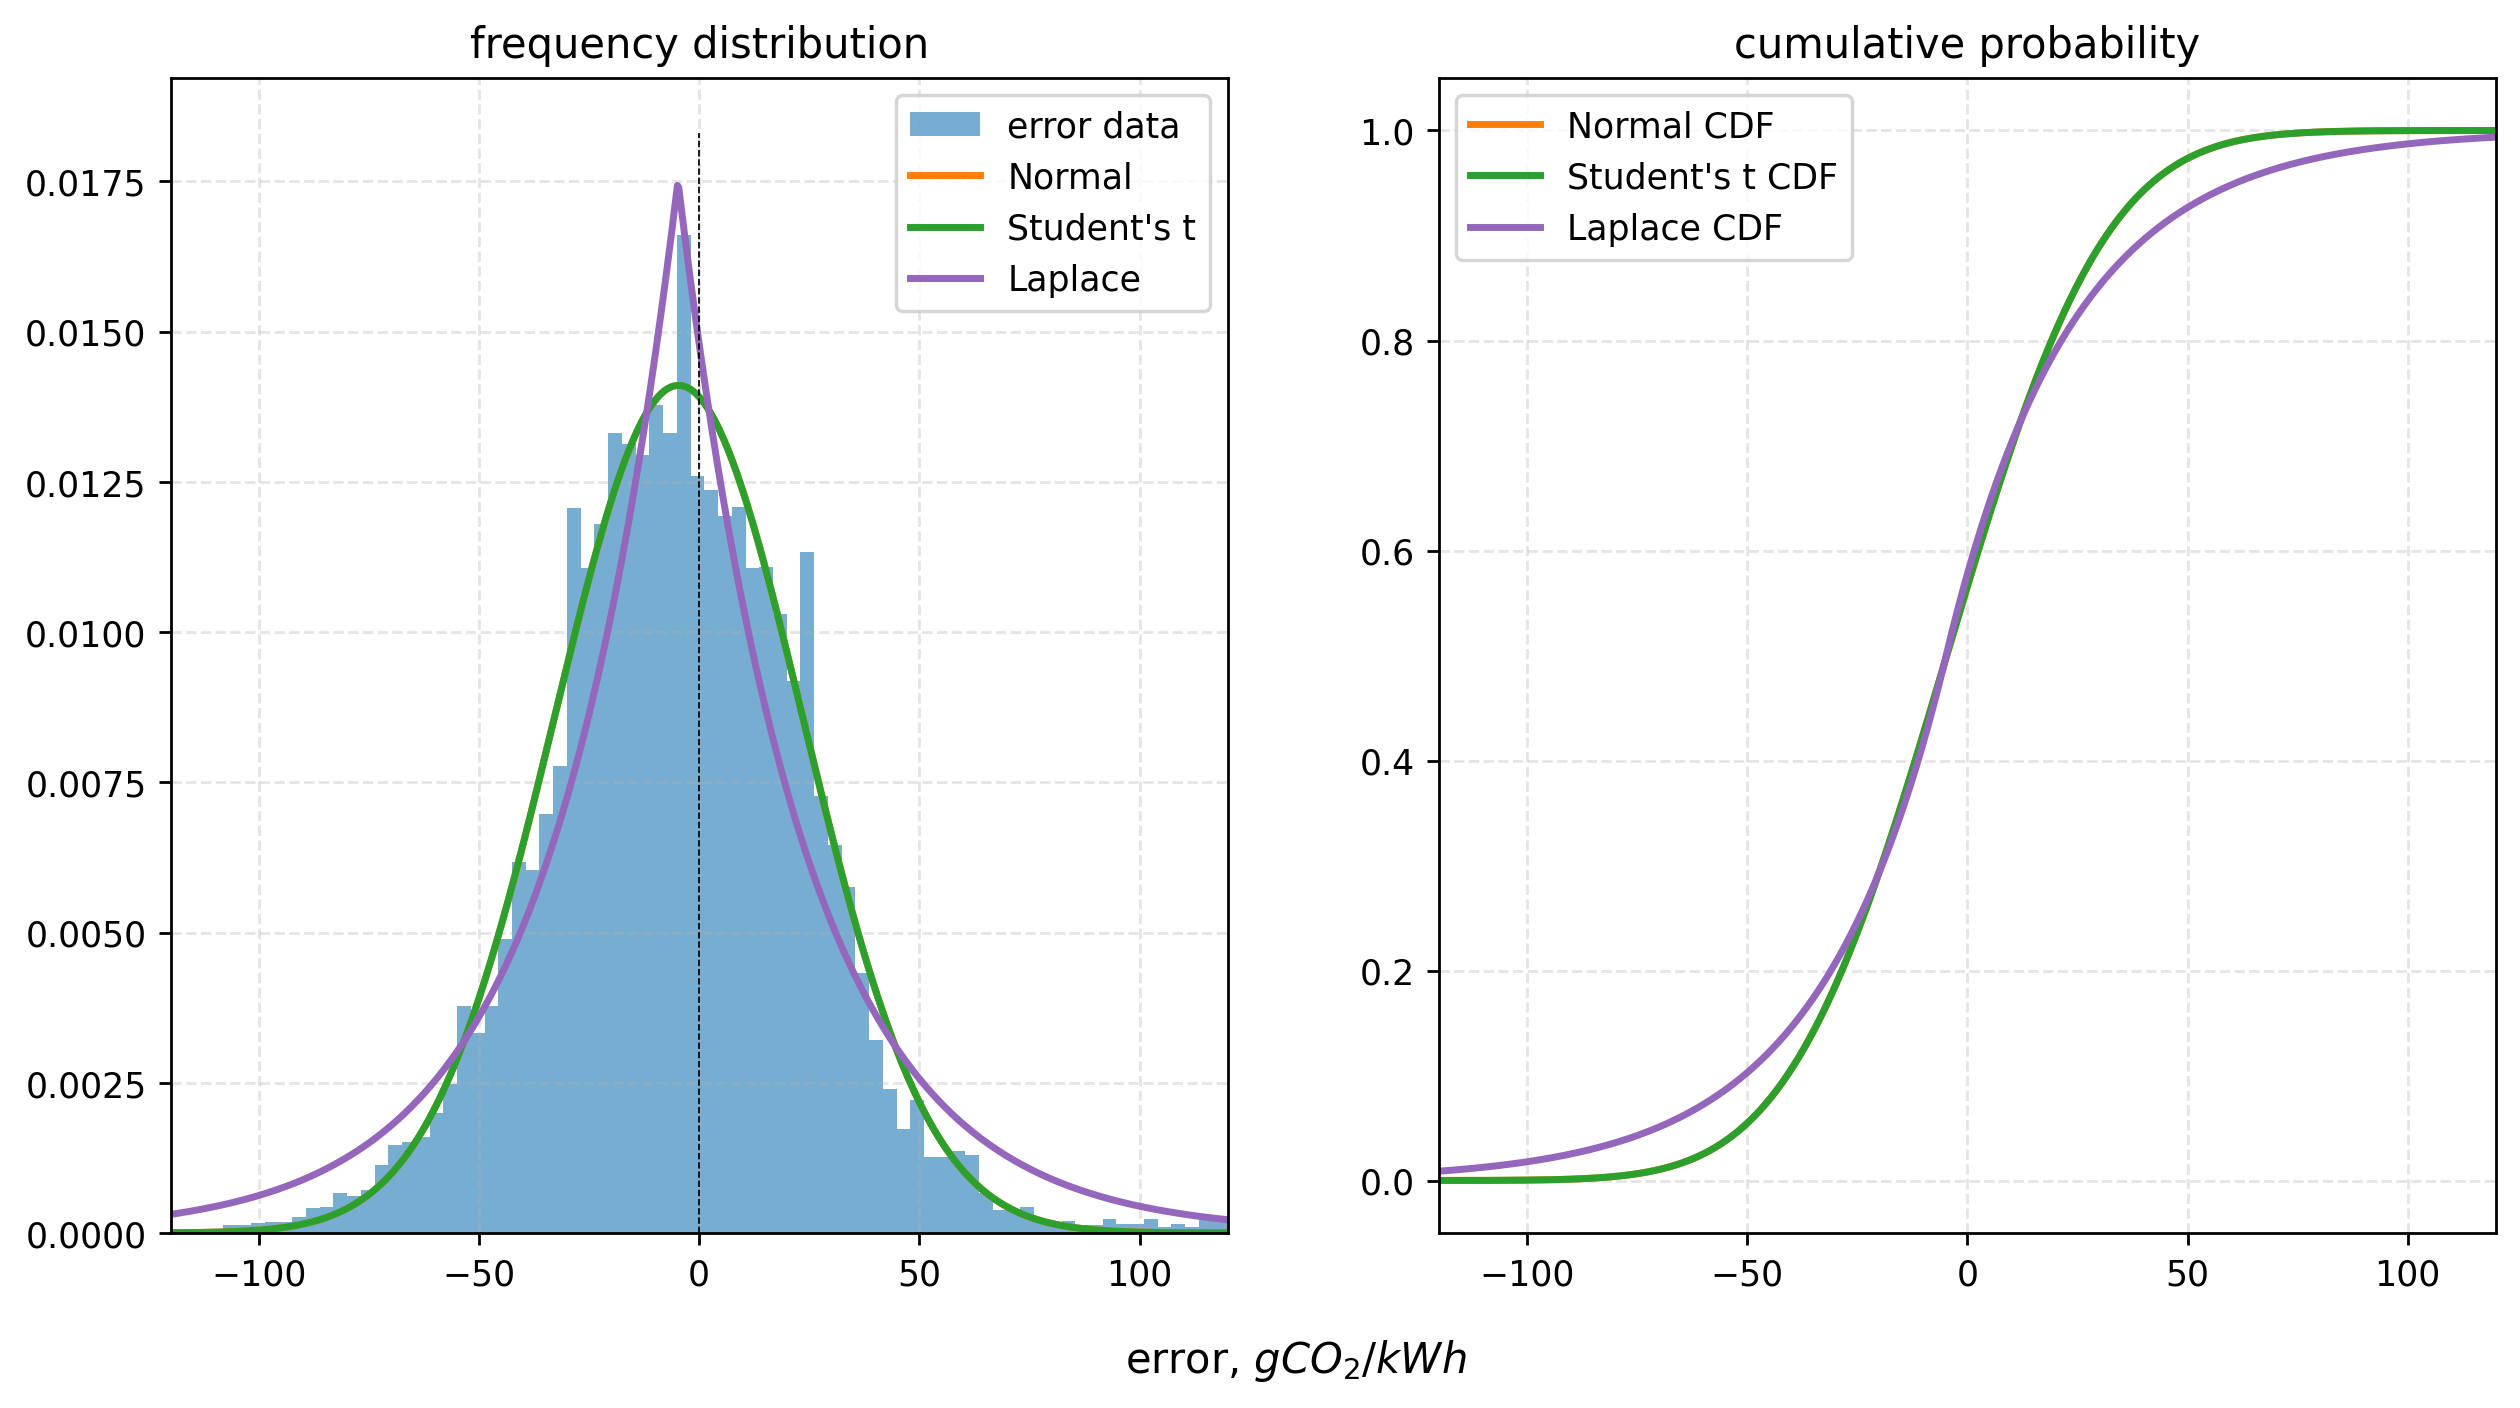

In [22]:
fig, df_extreme_probs = generate_distribution_plots(data_forecast_err,
                                  x_label="error, $gCO_2/kWh$",
                                  hist_label="error data",
                                  n_bins=100,
                                  x_min=-120,
                                  x_max=120,
                                  lookup_extreme_values=[20.5, 40.5, 40.5, 46.0],
                                 )
save_figure(fig, "./charts", "ci_forecast_error_distribution.png")

df_extreme_probs

### Error magnitude given an acceptable probability

For this, we use the inverse CDF.